# Задача "Прогноз состава сырья"

## Описание задачи
На нефтехимические заводы СИБУР сырье (широкая фракция легких углеводородов - ШФЛУ) поступает по трубопроводу. Трубопровод наполняется на нескольких станциях подкачки, которые расположены последовательно на пути к потребителю.

Состав ШФЛУ меняется на каждой станции с течением времени и, таким образом, меняется итоговый состав ШФЛУ, которую получает потребитель. Имея достоверный прогноз по составу можно оптимизировать некоторые технологические процессы.

Вам предстоит построить прогноз состава поступающей по трубопроводу ШФЛУ на основании данных с последней перед потребителем станции подкачки. При этом геометрия трубопровода, расстояние от станции подкачки до потребителя и другие параметры трубопровода не раскрываются.

Метрикой в этой задаче служит средняя по всем целевым переменным MAPE.

## Данные
Данные содержат расходы сырья в т/ч для станции подкачки A (A_rate) и потребителя B (B_rate), а также массовые процентные доли различных компонент на станции A (A_CH4, A_C2H6, A_C3H8, A_iC4H10, A_nC4H10, A_iC5H12, A_nC5H12, A_C6H14).

Целевые переменные: массовые процентные доли нескольких компонент на станции B (B_C2H6, B_C3H8, B_iC4H10, B_nC4H10). Целевые переменные для тестового периода не содержат разрывов, поэтому загружаемое решение должно содержать все временные метки из тестового множества.

train_targets.csv - целевые переменные для тренировочного множества
train_features.csv - признаки для тренировочного множества
test_features.csv - признаки для тестового множества
sample_submission.csv - пример решения в правильном формате

## Вебинар
На вебинаре организаторы разъяснили немного условия задачи.
Есть трубопровод по которому подается ШФЛУ из сечения А в сечение В. По пути из А в В присутствует подкачка ШФЛУ более-менее стабильного состава. Расход данной подкачки можно определить на основании данных в условии задачи расходов в А и В.

G - массовый расход ШФЛУ, х - процентный массовый состав ШФЛУ по каждому компоненту

<center>
<img src="Schem.jpg">

Первое что приходит в голову - задача на **структуру потоков**.

Если бы были данные по устройству трубопровода (геометрия, топология, арматура), температура и давление ШФЛУ, результаты гидродинамических испытаний по структуре потока (кривые распределения времени пребывания, плотности распределения, кривые отклика) можно было бы попытаться создать модель (ячеечную или диффузионную), а также попробовать её решить численно, либо создать гибридную модель. Но данных таких нет и не всегда они бывают даже у датасайнтистов из Сибура...
    
    
Кстати, в интернете нашел интересную статью как раз по моделированию смешения и коэффициента продольного перемешивания (эффективная диффузия) - "*Новый метод расчета многопродуктовых магистральных
трубопроводов*", А.С. Дидковская

## Посмотрим на данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math as m

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_features = pd.read_csv('train_features.csv', header = 0, sep = ',')
test_features = pd.read_csv('test_features.csv', header = 0, sep = ',')
train_target = pd.read_csv('train_targets.csv', header = 0, sep = ',')

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [5]:
train_features[:]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 00:00:00  70.855017       NaN       NaN        NaN   
1     2020-01-01 00:30:00  70.826582       NaN       NaN        NaN   
2     2020-01-01 01:00:00  70.809637       NaN       NaN        NaN   
3     2020-01-01 01:30:00  69.994748       NaN       NaN        NaN   
4     2020-01-01 02:00:00  70.072762       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5803  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5804  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5805  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5806  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5807  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0           NaN        NaN       NaN       NaN       NaN  71.982789  
1           NaN        NaN       NaN       NaN       NaN  71.965098  
2           NaN        NaN       NaN       NaN       NaN  71.867409  
3           NaN        NaN       NaN       NaN       NaN  71.839126  
4           NaN        NaN       NaN       NaN       NaN  71.336921  
...         ...        ...       ...       ...       ...        ...  
5803  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  
5804  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  
5805  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  
5806  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  
5807  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  

[5808 rows x 11 columns]

In [6]:
train_features.corr()

A_rate     A_CH4    A_C2H6    A_C3H8  A_iC4H10  A_nC4H10  \
A_rate    1.000000  0.140528  0.437019  0.418836  0.017336 -0.430159   
A_CH4     0.140528  1.000000  0.335366  0.200776 -0.154180 -0.337805   
A_C2H6    0.437019  0.335366  1.000000  0.527549 -0.100987 -0.701938   
A_C3H8    0.418836  0.200776  0.527549  1.000000  0.486148 -0.709767   
A_iC4H10  0.017336 -0.154180 -0.100987  0.486148  1.000000  0.199295   
A_nC4H10 -0.430159 -0.337805 -0.701938 -0.709767  0.199295  1.000000   
A_iC5H12 -0.399400 -0.150923 -0.514814 -0.940113 -0.645688  0.546690   
A_nC5H12 -0.367528 -0.155106 -0.540416 -0.930008 -0.659884  0.523956   
A_C6H14  -0.318311 -0.128191 -0.407348 -0.881589 -0.686246  0.384840   
B_rate    0.962491  0.051154  0.341268  0.231222 -0.167036 -0.273329   

          A_iC5H12  A_nC5H12   A_C6H14    B_rate  
A_rate   -0.399400 -0.367528 -0.318311  0.962491  
A_CH4    -0.150923 -0.155106 -0.128191  0.051154  
A_C2H6   -0.514814 -0.540416 -0.407348  0.341268  
A_C3H8   -0.940113 -0.930008 -0.881589  0.231222  
A_iC4H10 -0.645688 -0.659884 -0.686246 -0.167036  
A_nC4H10  0.546690  0.523956  0.384840 -0.273329  
A_iC5H12  1.000000  0.975426  0.862518 -0.224065  
A_nC5H12  0.975426  1.000000  0.877563 -0.178315  
A_C6H14   0.862518  0.877563  1.000000 -0.122962  
B_rate   -0.224065 -0.178315 -0.122962  1.000000

In [7]:
train_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  5807.000000  4849.000000  4849.000000  4849.000000  4849.000000   
mean     59.346948     0.159890     4.290739    37.990406    17.343168   
std      20.684895     0.068488     0.912565     3.756424     0.754301   
min       0.000321     0.008045     0.280524    11.345740    11.143152   
25%      61.846908     0.109331     3.971011    37.647968    17.018272   
50%      67.010148     0.139924     4.485758    38.618187    17.327200   
75%      69.734038     0.212163     4.844390    39.402360    17.685803   
max      74.560399     0.471429     6.418897    42.860283    20.353500   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  4849.000000  4849.000000  4849.000000  4849.000000  5675.000000  
mean     24.413897     4.948636     4.809805     5.995740    64.817202  
std       1.274795     1.230539     1.285549     1.543956    10.696414  
min      18.655932     3.033678     1.338103     2.924722     0.000000  
25%      23.746663     4.462670     4.353103     5.574106    63.852030  
50%      24.138643     4.684908     4.619459     5.708216    68.583359  
75%      24.615843     5.086816     4.925770     6.032535    71.171153  
max      35.498867    13.812560    14.845480    30.656385    89.958390

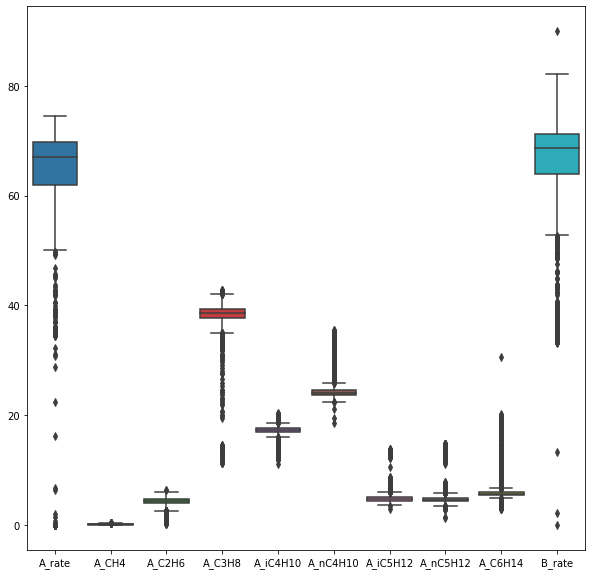

In [8]:
plt.rcParams["figure.figsize"] = (10,10)
sns.boxplot(data=train_features)

In [9]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [10]:
train_features.info()
train_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5808 non-null   object 
 1   A_rate     5807 non-null   float64
 2   A_CH4      4849 non-null   float64
 3   A_C2H6     4849 non-null   float64
 4   A_C3H8     4849 non-null   float64
 5   A_iC4H10   4849 non-null   float64
 6   A_nC4H10   4849 non-null   float64
 7   A_iC5H12   4849 non-null   float64
 8   A_nC5H12   4849 non-null   float64
 9   A_C6H14    4849 non-null   float64
 10  B_rate     5675 non-null   float64
dtypes: float64(10), object(1)
memory usage: 499.2+ KB


(5808, 11)

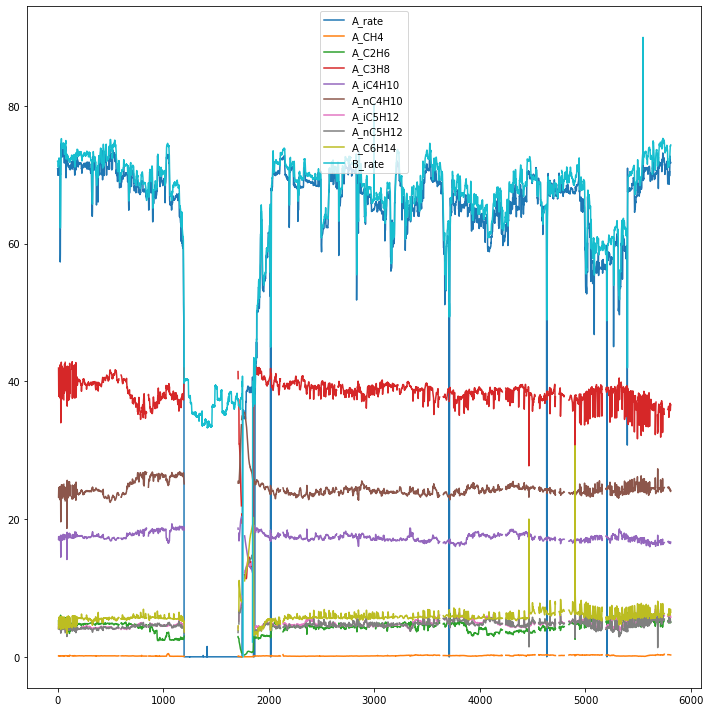

In [11]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [12]:
train_features[train_features["A_rate"] <= 40]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
1197  2020-01-25 22:30:00  37.634787  0.068959  2.783333  39.613317   
1198  2020-01-25 23:00:00   0.001294  0.070249  2.903388  41.168760   
1199  2020-01-25 23:30:00   0.001701  0.071737  2.994731  41.935570   
1200  2020-01-26 00:00:00   0.001525       NaN       NaN        NaN   
1201  2020-01-26 00:30:00   0.001055       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5201  2020-04-18 08:30:00  39.827838  0.240746  5.309529  38.752616   
5202  2020-04-18 09:00:00   0.002014  0.247586  5.250514  38.680070   
5203  2020-04-18 09:30:00   0.001633  0.261290  4.818443  38.907820   
5204  2020-04-18 10:00:00  38.215334  0.276025  4.567278  38.848842   
5396  2020-04-22 10:00:00  30.749718  0.110907  5.681407  38.414870   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
1197  18.374810  25.521723  4.473425  3.987337  5.163005  45.833590  
1198  18.650220  25.298560  4.232059  3.601516  4.062176  42.446206  
1199  18.765710  25.119170  4.089573  3.390231  3.620386  39.727496  
1200        NaN        NaN       NaN       NaN       NaN  39.972873  
1201        NaN        NaN       NaN       NaN       NaN  40.089745  
...         ...        ...       ...       ...       ...        ...  
5201  17.415626  24.286268  4.272327  4.035304  5.629434  56.099281  
5202  17.369883  24.286207  4.326687  4.089799  5.691831  48.813637  
5203  17.416410  24.441860  4.462670  4.187992  5.451690  49.964670  
5204  17.454773  24.491840  4.555090  4.260572  5.496899  48.964665  
5396  17.581315  24.102620  4.432917  3.888675  5.740080  54.846246  

[694 rows x 11 columns]

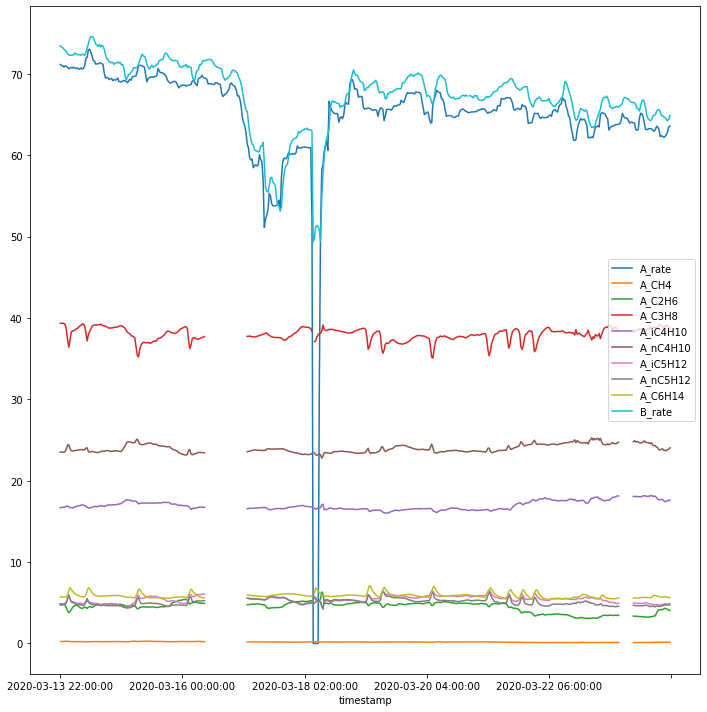

In [13]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[3500:4000].plot('timestamp')

# make room for tick labels
plt.tight_layout()


plt.show()

In [14]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447  
...         ...        ...       ...       ...       ...        ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667  

[3984 rows x 11 columns]

In [15]:
test_features.isnull().sum()

timestamp       0
A_rate       1142
A_CH4         456
A_C2H6        451
A_C3H8        452
A_iC4H10      452
A_nC4H10      452
A_iC5H12      456
A_nC5H12      456
A_C6H14       455
B_rate          5
dtype: int64

In [16]:
test_features.info()
test_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3984 non-null   object 
 1   A_rate     2842 non-null   float64
 2   A_CH4      3528 non-null   float64
 3   A_C2H6     3533 non-null   float64
 4   A_C3H8     3532 non-null   float64
 5   A_iC4H10   3532 non-null   float64
 6   A_nC4H10   3532 non-null   float64
 7   A_iC5H12   3528 non-null   float64
 8   A_nC5H12   3528 non-null   float64
 9   A_C6H14    3529 non-null   float64
 10  B_rate     3979 non-null   float64
dtypes: float64(10), object(1)
memory usage: 342.5+ KB


(3984, 11)

In [17]:
test_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  2842.000000  3528.000000  3533.000000  3532.000000  3532.000000   
mean     69.884320     0.162207     4.467679    39.109041    17.397629   
std       2.975072     0.051789     0.475805     2.194943     1.178583   
min       0.001292     0.000000     0.000000     3.891164     0.000000   
25%      69.168728     0.126446     4.236493    38.392097    16.856905   
50%      70.152686     0.147803     4.464768    39.061776    17.276783   
75%      71.289177     0.173982     4.731939    40.305470    18.068539   
max      74.346769     0.390817     6.551086   100.000000    54.028570   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  3532.000000  3528.000000  3528.000000  3529.000000  3979.000000  
mean     23.899568     4.871338     4.450333     5.613259    72.461288  
std       0.851144     0.629635     0.666401     2.049381     2.221912  
min       0.000000     0.000000     0.000000     0.000000    44.154610  
25%      23.579122     4.381023     3.842573     4.748398    71.653297  
50%      23.898327     4.775210     4.565247     5.943392    72.612522  
75%      24.259839     5.196619     4.922047     6.127190    73.800168  
max      34.284363    13.819660    11.846500    83.718820    94.243585

По максимальным значениям можно обнаружить наличие выбросов

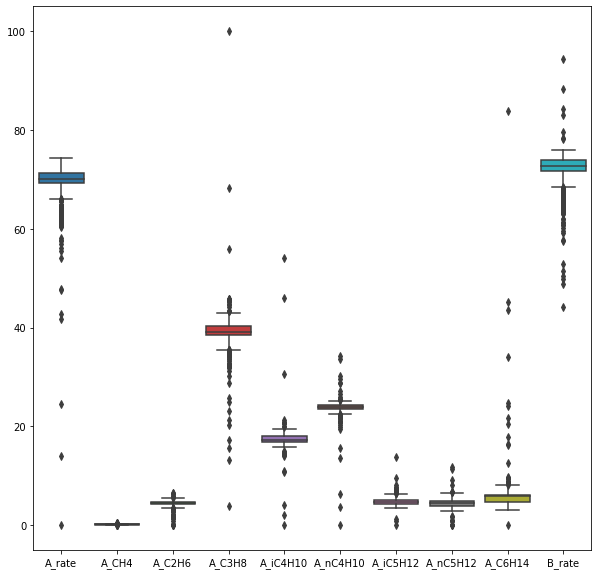

In [18]:
sns.boxplot(data=test_features)

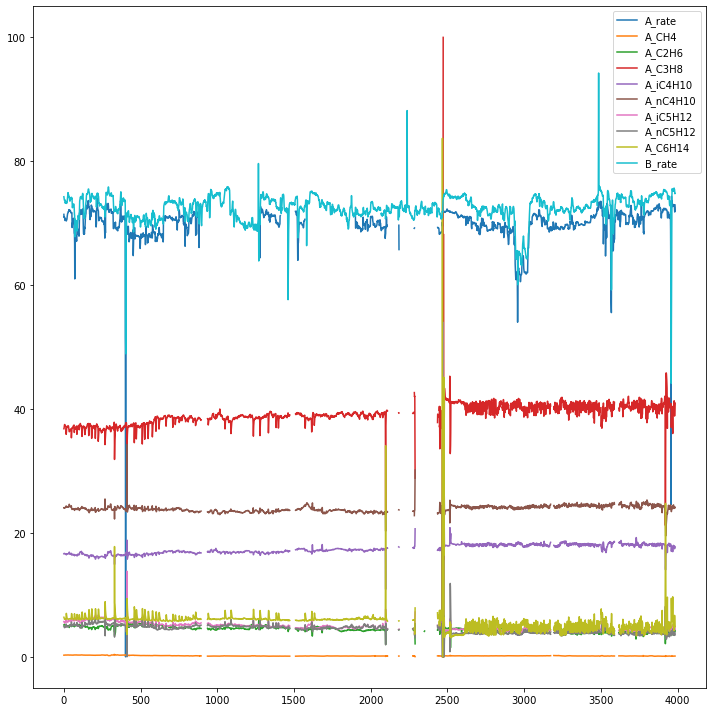

In [19]:
plt.rcParams["figure.figsize"] = (10,10)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [20]:
#dict_clean = {'A_C3H8':45, 'A_iC4H10':30, 'A_C6H14':15}

In [21]:
#for i in range(1,test_features.shape[0]):
#    for j in dict_clean:
#        if test_features.loc[i,j] > dict_clean[j]:
#            test_features.loc[[i],[j]] = test_features.loc[[i-1],[j]]

In [22]:
train_target[:]

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0     2020-01-01 00:00:00  4.561979  39.015486  17.250740  24.301793
1     2020-01-01 00:30:00  4.550741  39.048915  17.229506  24.257461
2     2020-01-01 01:00:00  4.506793  38.766378  17.171621  24.236298
3     2020-01-01 01:30:00  4.584963  39.069360  17.218521  24.149843
4     2020-01-01 02:00:00  4.607483  38.817579  17.108668  24.049510
...                   ...       ...        ...        ...        ...
5803  2020-04-30 21:30:00  4.816865  35.539156  16.269938  24.770377
5804  2020-04-30 22:00:00  4.993286  36.067750  16.317757  24.729847
5805  2020-04-30 22:30:00  5.101574  36.275040  16.295460  24.629889
5806  2020-04-30 23:00:00  5.210675  36.872917  16.336359  24.438236
5807  2020-04-30 23:30:00  5.136487  35.860326  16.101509  24.426845

[5808 rows x 5 columns]

In [23]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [24]:
train_target.info()
train_target.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5808 non-null   object 
 1   B_C2H6     5624 non-null   float64
 2   B_C3H8     5628 non-null   float64
 3   B_iC4H10   5628 non-null   float64
 4   B_nC4H10   5628 non-null   float64
dtypes: float64(4), object(1)
memory usage: 227.0+ KB


(5808, 5)

In [25]:
train_target.describe()

B_C2H6       B_C3H8     B_iC4H10     B_nC4H10
count  5624.000000  5628.000000  5628.000000  5628.000000
mean      4.363701    37.742757    16.843028    24.171264
std       2.931240     2.218569     1.059827     1.480740
min       0.861025     0.026142     0.012764     0.019941
25%       3.503610    36.827096    16.548084    23.736470
50%       4.395271    37.750088    16.934576    24.147675
75%       4.680156    38.730979    17.292647    24.642044
max      91.573613    61.931856    19.235807    27.184879

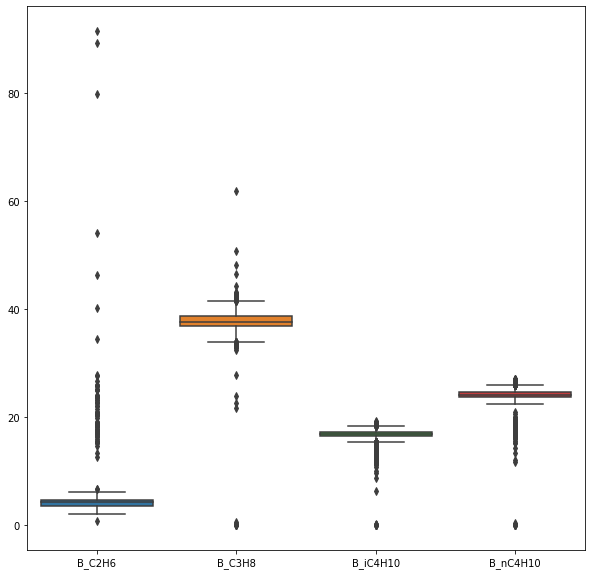

In [26]:
sns.boxplot(data=train_target)

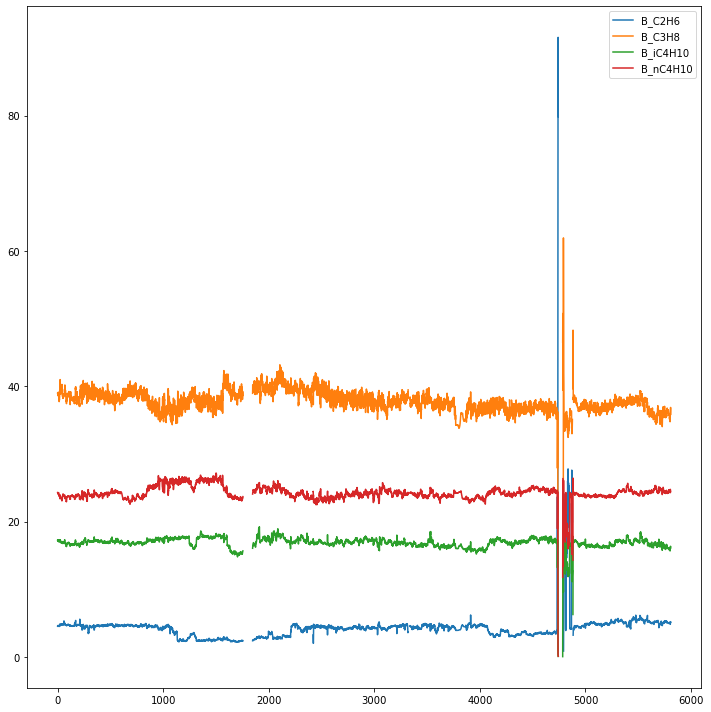

In [27]:
plt.rcParams["figure.figsize"] = (10,10)

train_target[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

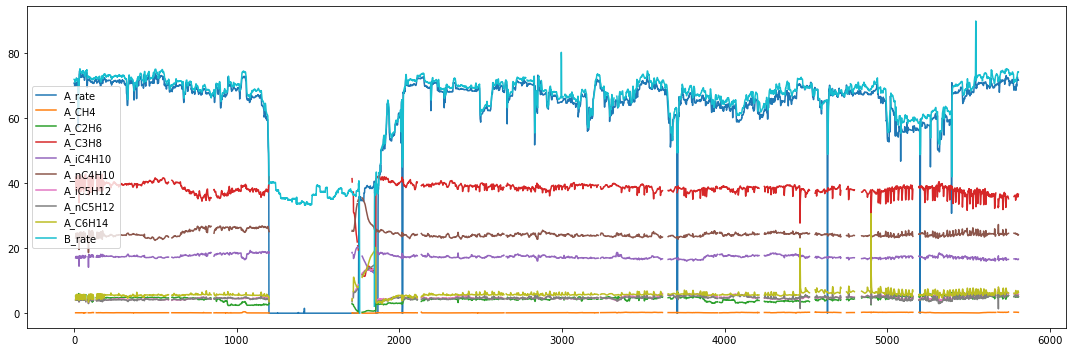

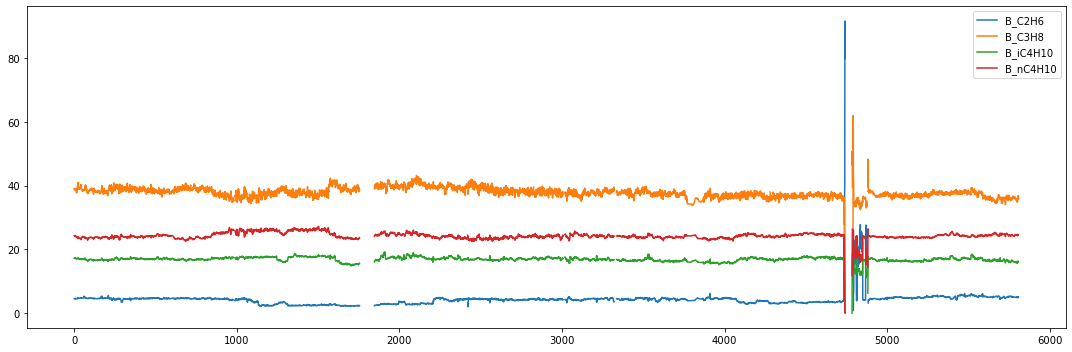

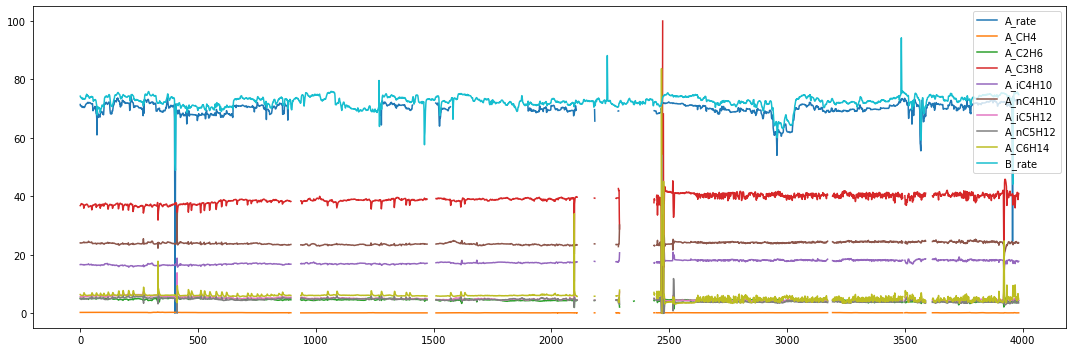

In [28]:
plt.rcParams["figure.figsize"] = (15,5)

train_features[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)

train_target[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [29]:
#dict_clean = {'B_C2H6':30, 'B_C3H8':50}

In [30]:
#for i in range(1,train_target.shape[0]):
#    for j in dict_clean:
#        if train_target.loc[i,j] > dict_clean[j]:
#            train_target.loc[[i],[j]] = train_target.loc[[i-1],[j]]

## Трансформация датасета

Попробуем оценить кажущийся отклик

In [31]:
train_features[['A_rate','B_rate']]

A_rate     B_rate
0     70.855017  71.982789
1     70.826582  71.965098
2     70.809637  71.867409
3     69.994748  71.839126
4     70.072762  71.336921
...         ...        ...
5803  72.009730  74.183355
5804  71.854180  74.213066
5805  71.783273  74.144367
5806  71.717743  74.320575
5807  71.730325  74.327170

[5808 rows x 2 columns]

In [32]:
derivatives_A = pd.DataFrame()
derivatives_B = pd.DataFrame()

derivatives_A['der_A_rate']=[]
derivatives_B ['der_B_rate']=[]

for i in range(train_features[['A_rate','B_rate']].shape[1]):
    for j in range(train_features[['A_rate','B_rate']].shape[0]-1):
        x = train_features[['A_rate','B_rate']].iloc[j,i]
        y = train_features[['A_rate','B_rate']].iloc[j+1,i]
        
        if i == 0:
            new_line = {'der_A_rate':(y-x)/30}
            derivatives_A = derivatives_A.append(new_line, ignore_index=True)
        else:
            new_line = {'der_B_rate':(y-x)/30}
            derivatives_B = derivatives_B.append(new_line, ignore_index=True)

In [33]:
derivatives = pd.concat([derivatives_A,derivatives_B.reset_index(drop=True)], axis=1)
derivatives

der_A_rate  der_B_rate
0      -0.000948   -0.000590
1      -0.000565   -0.003256
2      -0.027163   -0.000943
3       0.002600   -0.016740
4      -0.002479   -0.000636
...          ...         ...
5802   -0.008466    0.006174
5803   -0.005185    0.000990
5804   -0.002364   -0.002290
5805   -0.002184    0.005874
5806    0.000419    0.000220

[5807 rows x 2 columns]

In [34]:
# Сдвиг по времени 0
(derivatives['der_A_rate'] - derivatives['der_B_rate']).apply(np.abs).mean()

0.016707230655472926

In [35]:
# Сдвиг по времени 30 минут
x = derivatives['der_A_rate'][0:-1]
y = derivatives['der_B_rate'][1:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.012438913385618582

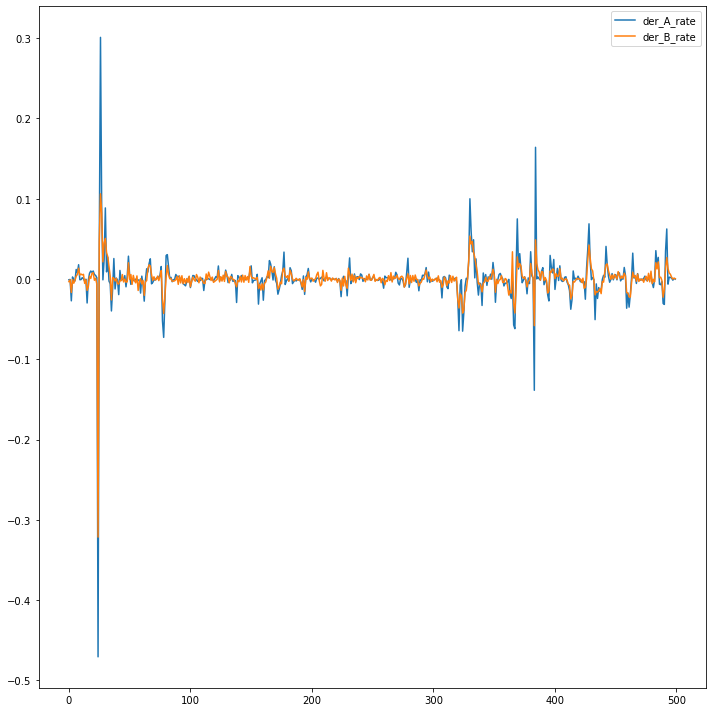

In [36]:
plt.rcParams["figure.figsize"] = (10,10)

z[0:500].plot()

# make room for tick labels
plt.tight_layout()

plt.show()

In [37]:
# Сдвиг по времени 60 минут
x = derivatives['der_A_rate'][0:-2]
y = derivatives['der_B_rate'][2:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.01659637858206412

In [38]:
# Сдвиг по времени 90 минут
x = derivatives['der_A_rate'][0:-3]
y = derivatives['der_B_rate'][3:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.0191065411244112

Кажущийся отклик 30 минут +- 15 минут

Теперь объединим признаки и таргеты на обучающей выборке. Заполним все пропуски предыдущими значениями. Строки в которых останутся NaN удалим

In [39]:
data = pd.concat([train_features,train_target.drop(['timestamp'], axis=1)], axis=1)
data.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
B_C2H6       184
B_C3H8       180
B_iC4H10     180
B_nC4H10     180
dtype: int64

In [40]:
data = data.ffill(axis = 0)
data.isnull().sum()

timestamp    0
A_rate       0
A_CH4        9
A_C2H6       9
A_C3H8       9
A_iC4H10     9
A_nC4H10     9
A_iC5H12     9
A_nC5H12     9
A_C6H14      9
B_rate       0
B_C2H6       0
B_C3H8       0
B_iC4H10     0
B_nC4H10     0
dtype: int64

In [41]:
NaNList = []
x = (data.isnull().sum(axis=1) > 0)
for i in range(x.shape[0]):
    if x[i] == True:
        NaNList.append(i)
data.drop(NaNList, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [42]:
data

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 04:30:00  71.055792  0.126244  5.242957  41.941480   
1     2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330   
2     2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656   
3     2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493   
4     2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510   
...                   ...        ...       ...       ...        ...   
5794  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5795  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5796  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5797  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5798  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6  \
0     17.064213  23.205953  4.184848  4.062079  4.110170  71.389674  4.532649   
1     17.440245  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543   
2     17.353362  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879   
3     17.098163  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837   
4     16.964787  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611   
...         ...        ...       ...       ...       ...        ...       ...   
5794  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  4.816865   
5795  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  4.993286   
5796  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  5.101574   
5797  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  5.210675   
5798  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  5.136487   

         B_C3H8   B_iC4H10   B_nC4H10  
0     38.604149  17.238489  24.275393  
1     38.510623  17.193441  24.242152  
2     39.124029  17.301609  24.211492  
3     38.247333  17.118282  24.044074  
4     37.985776  17.038811  23.931490  
...         ...        ...        ...  
5794  35.539156  16.269938  24.770377  
5795  36.067750  16.317757  24.729847  
5796  36.275040  16.295460  24.629889  
5797  36.872917  16.336359  24.438236  
5798  35.860326  16.101509  24.426845  

[5799 rows x 15 columns]

In [43]:
data_prev = data
data = data.rolling(25, min_periods=0).mean()

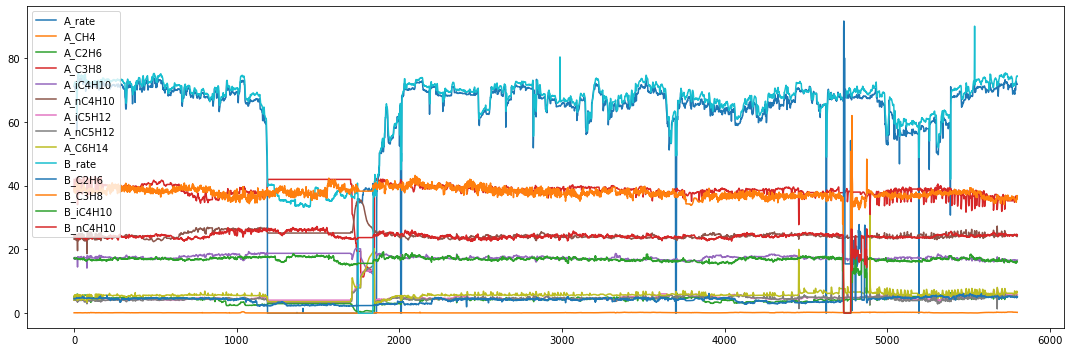

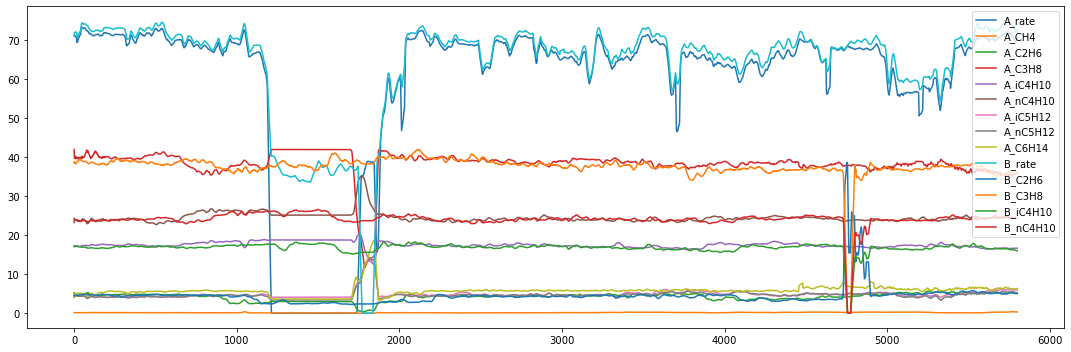

In [44]:
plt.rcParams["figure.figsize"] = (15,5)
data_prev[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[:].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

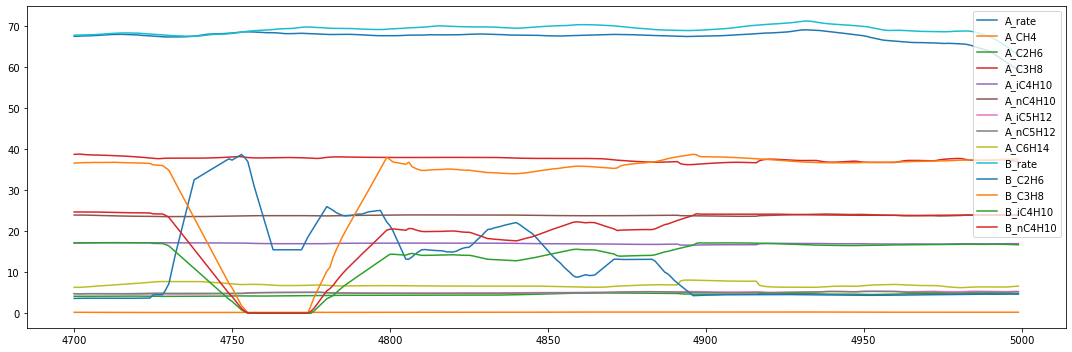

In [45]:
plt.rcParams["figure.figsize"] = (15,5)
data[4700:5000].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [46]:
data[data[:] < 0].isnull().sum()

A_rate      5799
A_CH4       5799
A_C2H6      5799
A_C3H8      5799
A_iC4H10    5799
A_nC4H10    5799
A_iC5H12    5799
A_nC5H12    5799
A_C6H14     5799
B_rate      5799
B_C2H6      5799
B_C3H8      5799
B_iC4H10    5799
B_nC4H10    5799
dtype: int64

In [47]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.055792  0.126244  5.242957  41.941480  17.064213  23.205953   
1     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
2     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
3     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
4     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
...         ...       ...       ...        ...        ...        ...   
5794  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5795  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5796  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5797  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5798  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.184848  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489   
1     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
2     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
3     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
4     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
...        ...       ...       ...        ...       ...        ...        ...   
5794  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5795  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5796  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5797  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5798  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10  
0     24.275393  
1     24.258773  
2     24.243013  
3     24.193278  
4     24.140920  
...         ...  
5794  24.464644  
5795  24.481749  
5796  24.497347  
5797  24.507734  
5798  24.517125  

[5799 rows x 14 columns]

In [48]:
monthList =[]
for i in data_prev['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [49]:
data['month'] = monthList

In [50]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.055792  0.126244  5.242957  41.941480  17.064213  23.205953   
1     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
2     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
3     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
4     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
...         ...       ...       ...        ...        ...        ...   
5794  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5795  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5796  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5797  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5798  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.184848  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489   
1     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
2     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
3     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
4     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
...        ...       ...       ...        ...       ...        ...        ...   
5794  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5795  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5796  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5797  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5798  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10  month  
0     24.275393      1  
1     24.258773      1  
2     24.243013      1  
3     24.193278      1  
4     24.140920      1  
...         ...    ...  
5794  24.464644      4  
5795  24.481749      4  
5796  24.497347      4  
5797  24.507734      4  
5798  24.517125      4  

[5799 rows x 15 columns]

In [51]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month'],
      dtype='object')

In [52]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

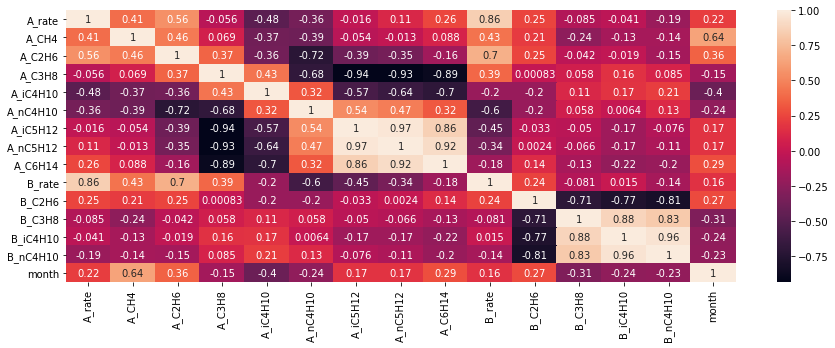

In [53]:
sns.heatmap(data.corr(), annot=True)

По [1] выпишем плотности сжиженных газов при 0 град Цельсия:

In [54]:
# кг/м3
ro_CH4 = 300.0 #Не нашел, указал из логических соображений
ro_C2H6 = 404.8
ro_C3H8 = 529.7
ro_iC4H10 = 581.0
ro_nC4H10 = 601.0
ro_iC5H12 = 639.2
ro_nC5H12 = 645.5
ro_C6H14 = 677.2

по [2] стр 65 выпишем динамическую вязкость сжиженных газов при 0 град Цельсия:

In [55]:
# Па*с
mu_CH4 = 10e-6 #Не нашел, указал из логических соображений
mu_C2H6 = 65e-6
mu_C3H8 = 140e-6
mu_iC4H10 = 225e-6
mu_nC4H10 = 215e-6
mu_iC5H12 = 285e-6
mu_nC5H12 = 295e-6
mu_C6H14 = 360e-6 #Не нашел, указал из логических соображений

по [3] выпишем молярные массы:

In [56]:
# кг/кмоль
M_CH4 = 16.04
M_C2H6 = 30.07
M_C3H8 = 44.1
M_iC4H10 = 58.12
M_nC4H10 = 58.12
M_iC5H12 = 72.15
M_nC5H12 = 72.15
M_C6H14 = 86.18

In [57]:
data['G_A_CH4'] = data['A_rate'] * data['A_CH4'] / 100
data['G_A_C2H6'] = data['A_rate'] * data['A_C2H6'] / 100
data['G_A_C3H8'] = data['A_rate'] * data['A_C3H8'] / 100
data['G_A_iC4H10'] = data['A_rate'] * data['A_iC4H10'] / 100
data['G_A_nC4H10'] = data['A_rate'] * data['A_nC4H10'] / 100
data['G_A_iC5H12'] = data['A_rate'] * data['A_iC5H12'] / 100
data['G_A_nC5H12'] = data['A_rate'] * data['A_nC5H12'] / 100
data['G_A_C6H14'] = data['A_rate'] * data['A_C6H14'] / 100

data['G_B_C2H6'] = data['B_rate'] * data['B_C2H6'] / 100
data['G_B_C3H8'] = data['B_rate'] * data['B_C3H8'] / 100
data['G_B_iC4H10'] = data['B_rate'] * data['B_iC4H10'] / 100
data['G_B_nC4H10'] = data['B_rate'] * data['B_nC4H10'] / 100

In [58]:
data['ro_mix_A'] = ((data['A_CH4'] / 100 / ro_CH4) + (data['A_C2H6'] / 100 / ro_C2H6) 
                  + (data['A_C3H8'] / 100 / ro_C3H8) + (data['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (data['A_nC4H10'] / 100 / ro_nC4H10) + (data['A_iC5H12'] / 100 / ro_iC5H12)
                  + (data['A_nC5H12'] / 100 / ro_nC5H12) + (data['A_C6H14'] / 100 / ro_C6H14))**-1

In [59]:
data['mu_mix_A'] = (((data['A_CH4'] / 100) * (data['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((data['A_C2H6'] / 100) * (data['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((data['A_C3H8'] / 100) * (data['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((data['A_iC4H10'] / 100) * (data['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((data['A_nC4H10'] / 100) * (data['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((data['A_iC5H12'] / 100) * (data['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((data['A_nC5H12'] / 100) * (data['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((data['A_C6H14'] / 100) * (data['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [60]:
data['w_A'] = (4*data['A_rate']*0.278)/(3.14*data['ro_mix_A']*0.16)
data['Re_A'] = (4*data['A_rate']*0.278)/(3.14*0.4*data['mu_mix_A'])

In [61]:
data['A_rate**2'] = data['A_rate']**2
data['sqrt_A_rate'] = data['A_rate'].apply(m.sqrt)
data['e**A_rate'] = data['A_rate'].apply(m.exp)
data['lg_A_rate'] = data['A_rate'].apply(m.log10)
data['ln_A_rate'] = data['A_rate'].apply(m.log)

data['B_rate**2'] = data['B_rate']**2
data['sqrt_B_rate'] = data['B_rate'].apply(m.sqrt)
data['e**B_rate'] = data['B_rate'].apply(m.exp)
#data['lg_B_rate'] = data['B_rate'].apply(m.log10)
#data['ln_B_rate'] = data['B_rate'].apply(m.log)

data['Re_A**2'] = data['Re_A']**2
data['sqrt_Re_A'] = data['Re_A'].apply(m.sqrt)
#data['e**Re_A'] = data['Re_A'].apply(m.exp)
data['lg_Re_A'] = data['Re_A'].apply(m.log10)
data['ln_Re_A'] = data['Re_A'].apply(m.log)

In [62]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.055792  0.126244  5.242957  41.941480  17.064213  23.205953  4.184848   
1  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
2  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
3  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
4  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489  24.275393   
1  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
2  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
3  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
4  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   

   month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  \
0      1  0.089704  3.725424  29.801851   12.125112   16.489174    2.973577   
1      1  0.084380  3.507886  28.822011   12.256473   16.885985    3.126080   
2      1  0.085882  3.458369  28.179261   12.278466   17.072465    3.231570   
3      1  0.089556  3.520068  28.198436   12.246353   17.025021    3.225281   
4      1  0.092099  3.589369  28.473852   12.208397   16.906464    3.179006   

   G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  G_B_iC4H10  G_B_nC4H10  \
0    2.886343   2.920514  3.235844  27.559376   12.306501   17.330124   
1    3.057606   3.261749  3.261401  27.603653   12.325097   17.367120   
2    3.179062   3.506462  3.287555  27.783881   12.365565   17.383997   
3    3.171124   3.521861  3.286083  27.734744   12.360900   17.373582   
4    3.117977   3.435498  3.287569  27.679363   12.351922   17.358515   

     ro_mix_A  mu_mix_A       w_A           Re_A    A_rate**2  sqrt_A_rate  \
0  557.275650  0.000152  0.282218  413051.697732  5048.925626     8.429460   
1  559.415129  0.000155  0.281087  406691.601290  5047.084656     8.428691   
2  560.509094  0.000156  0.280494  404402.122607  5045.476739     8.428020   
3  560.268157  0.000155  0.280643  405816.722617  5046.492171     8.428444   
4  559.631119  0.000154  0.280985  407882.237062  5047.321876     8.428790   

      e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  sqrt_B_rate     e**B_rate  \
0  7.230004e+30   1.851599   4.263465  5096.485564     8.449241  1.009582e+31   
1  7.136939e+30   1.851520   4.263283  5125.284167     8.461152  1.234853e+31   
2  7.056623e+30   1.851451   4.263124  5141.929142     8.468013  1.386952e+31   
3  7.107240e+30   1.851495   4.263224  5156.906896     8.474173  1.539518e+31   
4  7.148864e+30   1.851531   4.263307  5170.320863     8.479678  1.690130e+31   

        Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  
0  1.706117e+11  642.690982  5.616004  12.931328  
1  1.653981e+11  637.723766  5.609265  12.915810  
2  1.635411e+11  635.926193  5.606813  12.910165  
3  1.646872e+11  637.037458  5.608330  12.913657  
4  1.663679e+11  638.656588  5.610535  12.918734

In [63]:
Ct_A = pd.DataFrame({'Ct_A_C2H6':[np.nan],'Ct_A_C3H8':[np.nan],'Ct_A_iC4H10':[np.nan],
                     'Ct_A_nC4H10':[np.nan]})

Cx_A = pd.DataFrame({'Cx_A_C2H6':[np.nan],'Cx_A_C3H8':[np.nan],'Cx_A_iC4H10':[np.nan],
                     'Cx_A_nC4H10':[np.nan]})

G = data[['G_A_C2H6', 'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10',
          'G_B_C2H6', 'G_B_C3H8','G_B_iC4H10', 'G_B_nC4H10']]

In [64]:
for i in range(G.shape[0]-1):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i+1,j]
        new_line.update({Ct_A .columns[j]:(y-x)})
    Ct_A = Ct_A.append(new_line, ignore_index=True)

In [65]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.507886  28.822011   12.256473   16.885985  3.261401  27.603653   
2  3.458369  28.179261   12.278466   17.072465  3.287555  27.783881   
3  3.520068  28.198436   12.246353   17.025021  3.286083  27.734744   
4  3.589369  28.473852   12.208397   16.906464  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.325097   17.367120  
2   12.365565   17.383997  
3   12.360900   17.373582  
4   12.351922   17.358515

In [66]:
Ct_A 

Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10
0           NaN        NaN          NaN          NaN
1     -0.217538  -0.979840     0.131361     0.396811
2     -0.049517  -0.642750     0.021993     0.186480
3      0.061699   0.019175    -0.032113    -0.047444
4      0.069300   0.275416    -0.037955    -0.118557
...         ...        ...          ...          ...
5794  -0.009849   0.044844     0.010821     0.012842
5795  -0.006938   0.064296     0.017532     0.016865
5796   0.001945   0.052750     0.013821     0.012071
5797   0.003029   0.061467     0.015234     0.012173
5798  -0.000561   0.055675     0.016380     0.016305

[5799 rows x 4 columns]

In [67]:
for i in range(G.shape[0]-1):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i,j+4]
        new_line.update({Cx_A .columns[j]:(y-x)})
    Cx_A = Cx_A.append(new_line, ignore_index=True)

In [68]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.507886  28.822011   12.256473   16.885985  3.261401  27.603653   
2  3.458369  28.179261   12.278466   17.072465  3.287555  27.783881   
3  3.520068  28.198436   12.246353   17.025021  3.286083  27.734744   
4  3.589369  28.473852   12.208397   16.906464  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.325097   17.367120  
2   12.365565   17.383997  
3   12.360900   17.373582  
4   12.351922   17.358515

In [69]:
Cx_A

Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10
0           NaN        NaN          NaN          NaN
1     -0.489581  -2.242475     0.181389     0.840950
2     -0.246485  -1.218358     0.068624     0.481135
3     -0.170814  -0.395380     0.087099     0.311532
4     -0.233986  -0.463693     0.114547     0.348560
...         ...        ...          ...          ...
5794   0.034875   0.584620    -0.127066     0.500455
5795   0.041494   0.542537    -0.123969     0.518442
5796   0.053704   0.520633    -0.117063     0.542428
5797   0.060286   0.518827    -0.105062     0.572140
5798   0.068488   0.526622    -0.091283     0.596711

[5799 rows x 4 columns]

In [70]:
w = pd.DataFrame({'w_prev':[np.nan]})
j = pd.DataFrame({'w_prev':data['w_A']})
w = pd.concat([w,j], axis=0)
w = w.reset_index(drop=True)
w.drop(5799, axis=0, inplace=True)
w = w.reset_index(drop=True)
w

w_prev
0          NaN
1     0.282218
2     0.281087
3     0.280494
4     0.280643
...        ...
5794  0.274930
5795  0.275224
5796  0.275694
5797  0.276149
5798  0.276608

[5799 rows x 1 columns]

In [71]:
x = data
y = pd.concat([Cx_A,Ct_A,w], axis=1)
data = pd.concat([data,y], axis=1)

In [72]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.055792  0.126244  5.242957  41.941480  17.064213  23.205953  4.184848   
1  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
2  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
3  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
4  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489  24.275393   
1  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
2  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
3  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
4  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   

   month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  \
0      1  0.089704  3.725424  29.801851   12.125112   16.489174    2.973577   
1      1  0.084380  3.507886  28.822011   12.256473   16.885985    3.126080   
2      1  0.085882  3.458369  28.179261   12.278466   17.072465    3.231570   
3      1  0.089556  3.520068  28.198436   12.246353   17.025021    3.225281   
4      1  0.092099  3.589369  28.473852   12.208397   16.906464    3.179006   

   G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  G_B_iC4H10  G_B_nC4H10  \
0    2.886343   2.920514  3.235844  27.559376   12.306501   17.330124   
1    3.057606   3.261749  3.261401  27.603653   12.325097   17.367120   
2    3.179062   3.506462  3.287555  27.783881   12.365565   17.383997   
3    3.171124   3.521861  3.286083  27.734744   12.360900   17.373582   
4    3.117977   3.435498  3.287569  27.679363   12.351922   17.358515   

     ro_mix_A  mu_mix_A       w_A           Re_A    A_rate**2  sqrt_A_rate  \
0  557.275650  0.000152  0.282218  413051.697732  5048.925626     8.429460   
1  559.415129  0.000155  0.281087  406691.601290  5047.084656     8.428691   
2  560.509094  0.000156  0.280494  404402.122607  5045.476739     8.428020   
3  560.268157  0.000155  0.280643  405816.722617  5046.492171     8.428444   
4  559.631119  0.000154  0.280985  407882.237062  5047.321876     8.428790   

      e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  sqrt_B_rate     e**B_rate  \
0  7.230004e+30   1.851599   4.263465  5096.485564     8.449241  1.009582e+31   
1  7.136939e+30   1.851520   4.263283  5125.284167     8.461152  1.234853e+31   
2  7.056623e+30   1.851451   4.263124  5141.929142     8.468013  1.386952e+31   
3  7.107240e+30   1.851495   4.263224  5156.906896     8.474173  1.539518e+31   
4  7.148864e+30   1.851531   4.263307  5170.320863     8.479678  1.690130e+31   

        Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  Cx_A_C2H6  Cx_A_C3H8  \
0  1.706117e+11  642.690982  5.616004  12.931328        NaN        NaN   
1  1.653981e+11  637.723766  5.609265  12.915810  -0.489581  -2.242475   
2  1.635411e+11  635.926193  5.606813  12.910165  -0.246485  -1.218358   
3  1.646872e+11  637.037458  5.608330  12.913657  -0.170814  -0.395380   
4  1.663679e+11  638.656588  5.610535  12.918734  -0.233986  -0.463693   

   Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10  \
0          NaN          NaN        NaN        NaN          NaN          NaN   
1     0.181389     0.840950  -0.217538  -0.979840     0.131361     0.396811   
2     0.068624     0.481135  -0.049517  -0.642750     0.021993     0.186480   
3     0.087099     0.311532   0.061699   0.019175    -0.032113    -0.047444   
4     0.114547     0.348560   0.069300   0.275416    -0.037955    -0.118557   

     w_prev  
0       NaN  
1  0.282218  
2  0.281087  
3  0.280494  
4  0.280643

In [73]:
data.drop(0, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [74]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
1  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
2  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
3  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   
4  71.033900  0.129398  5.059953  40.298217  17.185181  23.729739  4.436506   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
1  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
2  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
3  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   
4  4.346012  4.756399  71.996468  4.566859  38.369108  17.140317  24.083498   

   month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  \
0      1  0.084380  3.507886  28.822011   12.256473   16.885985    3.126080   
1      1  0.085882  3.458369  28.179261   12.278466   17.072465    3.231570   
2      1  0.089556  3.520068  28.198436   12.246353   17.025021    3.225281   
3      1  0.092099  3.589369  28.473852   12.208397   16.906464    3.179006   
4      1  0.091916  3.594282  28.625395   12.207304   16.856159    3.151423   

   G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  G_B_iC4H10  G_B_nC4H10  \
0    3.057606   3.261749  3.261401  27.603653   12.325097   17.367120   
1    3.179062   3.506462  3.287555  27.783881   12.365565   17.383997   
2    3.171124   3.521861  3.286083  27.734744   12.360900   17.373582   
3    3.117977   3.435498  3.287569  27.679363   12.351922   17.358515   
4    3.087142   3.378656  3.287977  27.624403   12.340423   17.339268   

     ro_mix_A  mu_mix_A       w_A           Re_A    A_rate**2  sqrt_A_rate  \
0  559.415129  0.000155  0.281087  406691.601290  5047.084656     8.428691   
1  560.509094  0.000156  0.280494  404402.122607  5045.476739     8.428020   
2  560.268157  0.000155  0.280643  405816.722617  5046.492171     8.428444   
3  559.631119  0.000154  0.280985  407882.237062  5047.321876     8.428790   
4  559.383748  0.000154  0.281068  408308.687585  5045.814882     8.428161   

      e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  sqrt_B_rate     e**B_rate  \
0  7.136939e+30   1.851520   4.263283  5125.284167     8.461152  1.234853e+31   
1  7.056623e+30   1.851451   4.263124  5141.929142     8.468013  1.386952e+31   
2  7.107240e+30   1.851495   4.263224  5156.906896     8.474173  1.539518e+31   
3  7.148864e+30   1.851531   4.263307  5170.320863     8.479678  1.690130e+31   
4  7.073439e+30   1.851466   4.263157  5183.491371     8.485073  1.852118e+31   

        Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  Cx_A_C2H6  Cx_A_C3H8  \
0  1.653981e+11  637.723766  5.609265  12.915810  -0.489581  -2.242475   
1  1.635411e+11  635.926193  5.606813  12.910165  -0.246485  -1.218358   
2  1.646872e+11  637.037458  5.608330  12.913657  -0.170814  -0.395380   
3  1.663679e+11  638.656588  5.610535  12.918734  -0.233986  -0.463693   
4  1.667160e+11  638.990366  5.610989  12.919779  -0.301800  -0.794489   

   Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10  \
0     0.181389     0.840950  -0.217538  -0.979840     0.131361     0.396811   
1     0.068624     0.481135  -0.049517  -0.642750     0.021993     0.186480   
2     0.087099     0.311532   0.061699   0.019175    -0.032113    -0.047444   
3     0.114547     0.348560   0.069300   0.275416    -0.037955    -0.118557   
4     0.143525     0.452051   0.004913   0.151542    -0.001093    -0.050305   

     w_prev  
0  0.282218  
1  0.281087  
2  0.280494  
3  0.280643  
4  0.280985

In [75]:
data['Cx_A_C2H6**2'] = data['Cx_A_C2H6']**2
data['Cx_A_C3H8**2'] = data['Cx_A_C3H8']**2
data['Cx_A_iC4H10**2'] = data['Cx_A_iC4H10']**2
data['Cx_A_nC4H10**2'] = data['Cx_A_nC4H10']**2

data['E_C2H6'] = (data['Ct_A_C2H6'] + data['w_prev'] * data['Cx_A_C2H6'])/ data['Cx_A_C2H6**2']
data['E_C3H8'] = (data['Ct_A_C3H8'] + data['w_prev'] * data['Cx_A_C3H8'])/ data['Cx_A_C3H8**2']
data['E_iC4H10'] = (data['Ct_A_iC4H10'] + data['w_prev'] * data['Cx_A_iC4H10'])/ data['Cx_A_iC4H10**2']
data['E_nC4H10'] = (data['Ct_A_nC4H10'] + data['w_prev'] * data['Cx_A_nC4H10'])/ data['Cx_A_nC4H10**2']

data['Pe_ef_C2H6'] = data['w_prev'] / data['E_C2H6']
data['Pe_ef_C3H8'] = data['w_prev'] / data['E_C3H8']
data['Pe_ef_iC4H10'] = data['w_prev'] / data['E_iC4H10']
data['Pe_ef_nC4H10'] = data['w_prev'] / data['E_nC4H10']

In [76]:
data['Pe_ef_C2H6**2'] = data['Pe_ef_C2H6']**2
#data['sqrt_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.sqrt)
#data['e**Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.exp)
#data['lg_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log10)
#data['ln_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log)

data['Pe_ef_C3H8**2'] = data['Pe_ef_C3H8']**2
#data['sqrt_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.sqrt)
#data['e**Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.exp)
#data['lg_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log10)
#data['ln_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
#data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
#data['e**Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.exp)
#data['lg_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
#data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
#data['e**Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.exp)
#data['lg_Pe_ef_iC4H10e'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

In [77]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
1     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
2     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
3     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
4     71.033900  0.129398  5.059953  40.298217  17.185181  23.729739   
...         ...       ...       ...        ...        ...        ...   
5793  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5794  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5795  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5796  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5797  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
1     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
2     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
3     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
4     4.436506  4.346012  4.756399  71.996468  4.566859  38.369108  17.140317   
...        ...       ...       ...        ...       ...        ...        ...   
5793  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5794  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5795  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5796  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5797  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  \
0     24.258773      1  0.084380  3.507886  28.822011   12.256473   16.885985   
1     24.243013      1  0.085882  3.458369  28.179261   12.278466   17.072465   
2     24.193278      1  0.089556  3.520068  28.198436   12.246353   17.025021   
3     24.140920      1  0.092099  3.589369  28.473852   12.208397   16.906464   
4     24.083498      1  0.091916  3.594282  28.625395   12.207304   16.856159   
...         ...    ...       ...       ...        ...         ...         ...   
5793  24.464644      4  0.218365  3.572406  25.245525   11.661197   17.125750   
5794  24.481749      4  0.215943  3.565468  25.309821   11.678729   17.142614   
5795  24.497347      4  0.215254  3.567413  25.362570   11.692550   17.154685   
5796  24.507734      4  0.214325  3.570442  25.424037   11.707783   17.166859   
5797  24.517125      4  0.213048  3.569881  25.479712   11.724163   17.183164   

      G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  G_B_iC4H10  \
0       3.126080    3.057606   3.261749  3.261401  27.603653   12.325097   
1       3.231570    3.179062   3.506462  3.287555  27.783881   12.365565   
2       3.225281    3.171124   3.521861  3.286083  27.734744   12.360900   
3       3.179006    3.117977   3.435498  3.287569  27.679363   12.351922   
4       3.151423    3.087142   3.378656  3.287977  27.624403   12.340423   
...          ...         ...        ...       ...        ...         ...   
5793    4.133846    3.641633   4.373171  3.613900  25.788062   11.537228   
5794    4.141024    3.646513   4.399564  3.619171  25.830453   11.561665   
5795    4.146153    3.654012   4.426818  3.627698  25.881397   11.587488   
5796    4.148601    3.657421   4.447953  3.638930  25.950659   11.616500   
5797    4.152003    3.661481   4.466263  3.648088  25.981607   11.638576   

      G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A    A_rate**2  \
0      17.367120  559.415129  0.000155  0.281087  406691.601290  5047.084656   
1      17.383997  560.509094  0.000156  0.280494  404402.122607  5045.476739   
2      17.373582  560.268157  0.000155  0.280

In [78]:
last_line = data[-1:]

In [79]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10', 'ro_mix_A',
       'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate', 'e**A_rate',
       'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate', 'e**B_rate',
       'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6', 'Cx_A_C3H8',
       'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8', 'Ct_A_iC4H10',
       'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
      dtype='object')

In [80]:
x = data.drop(labels=['B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10',
                      'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10'], axis=1)

y = data[['B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10', 
                'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10']]

In [81]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

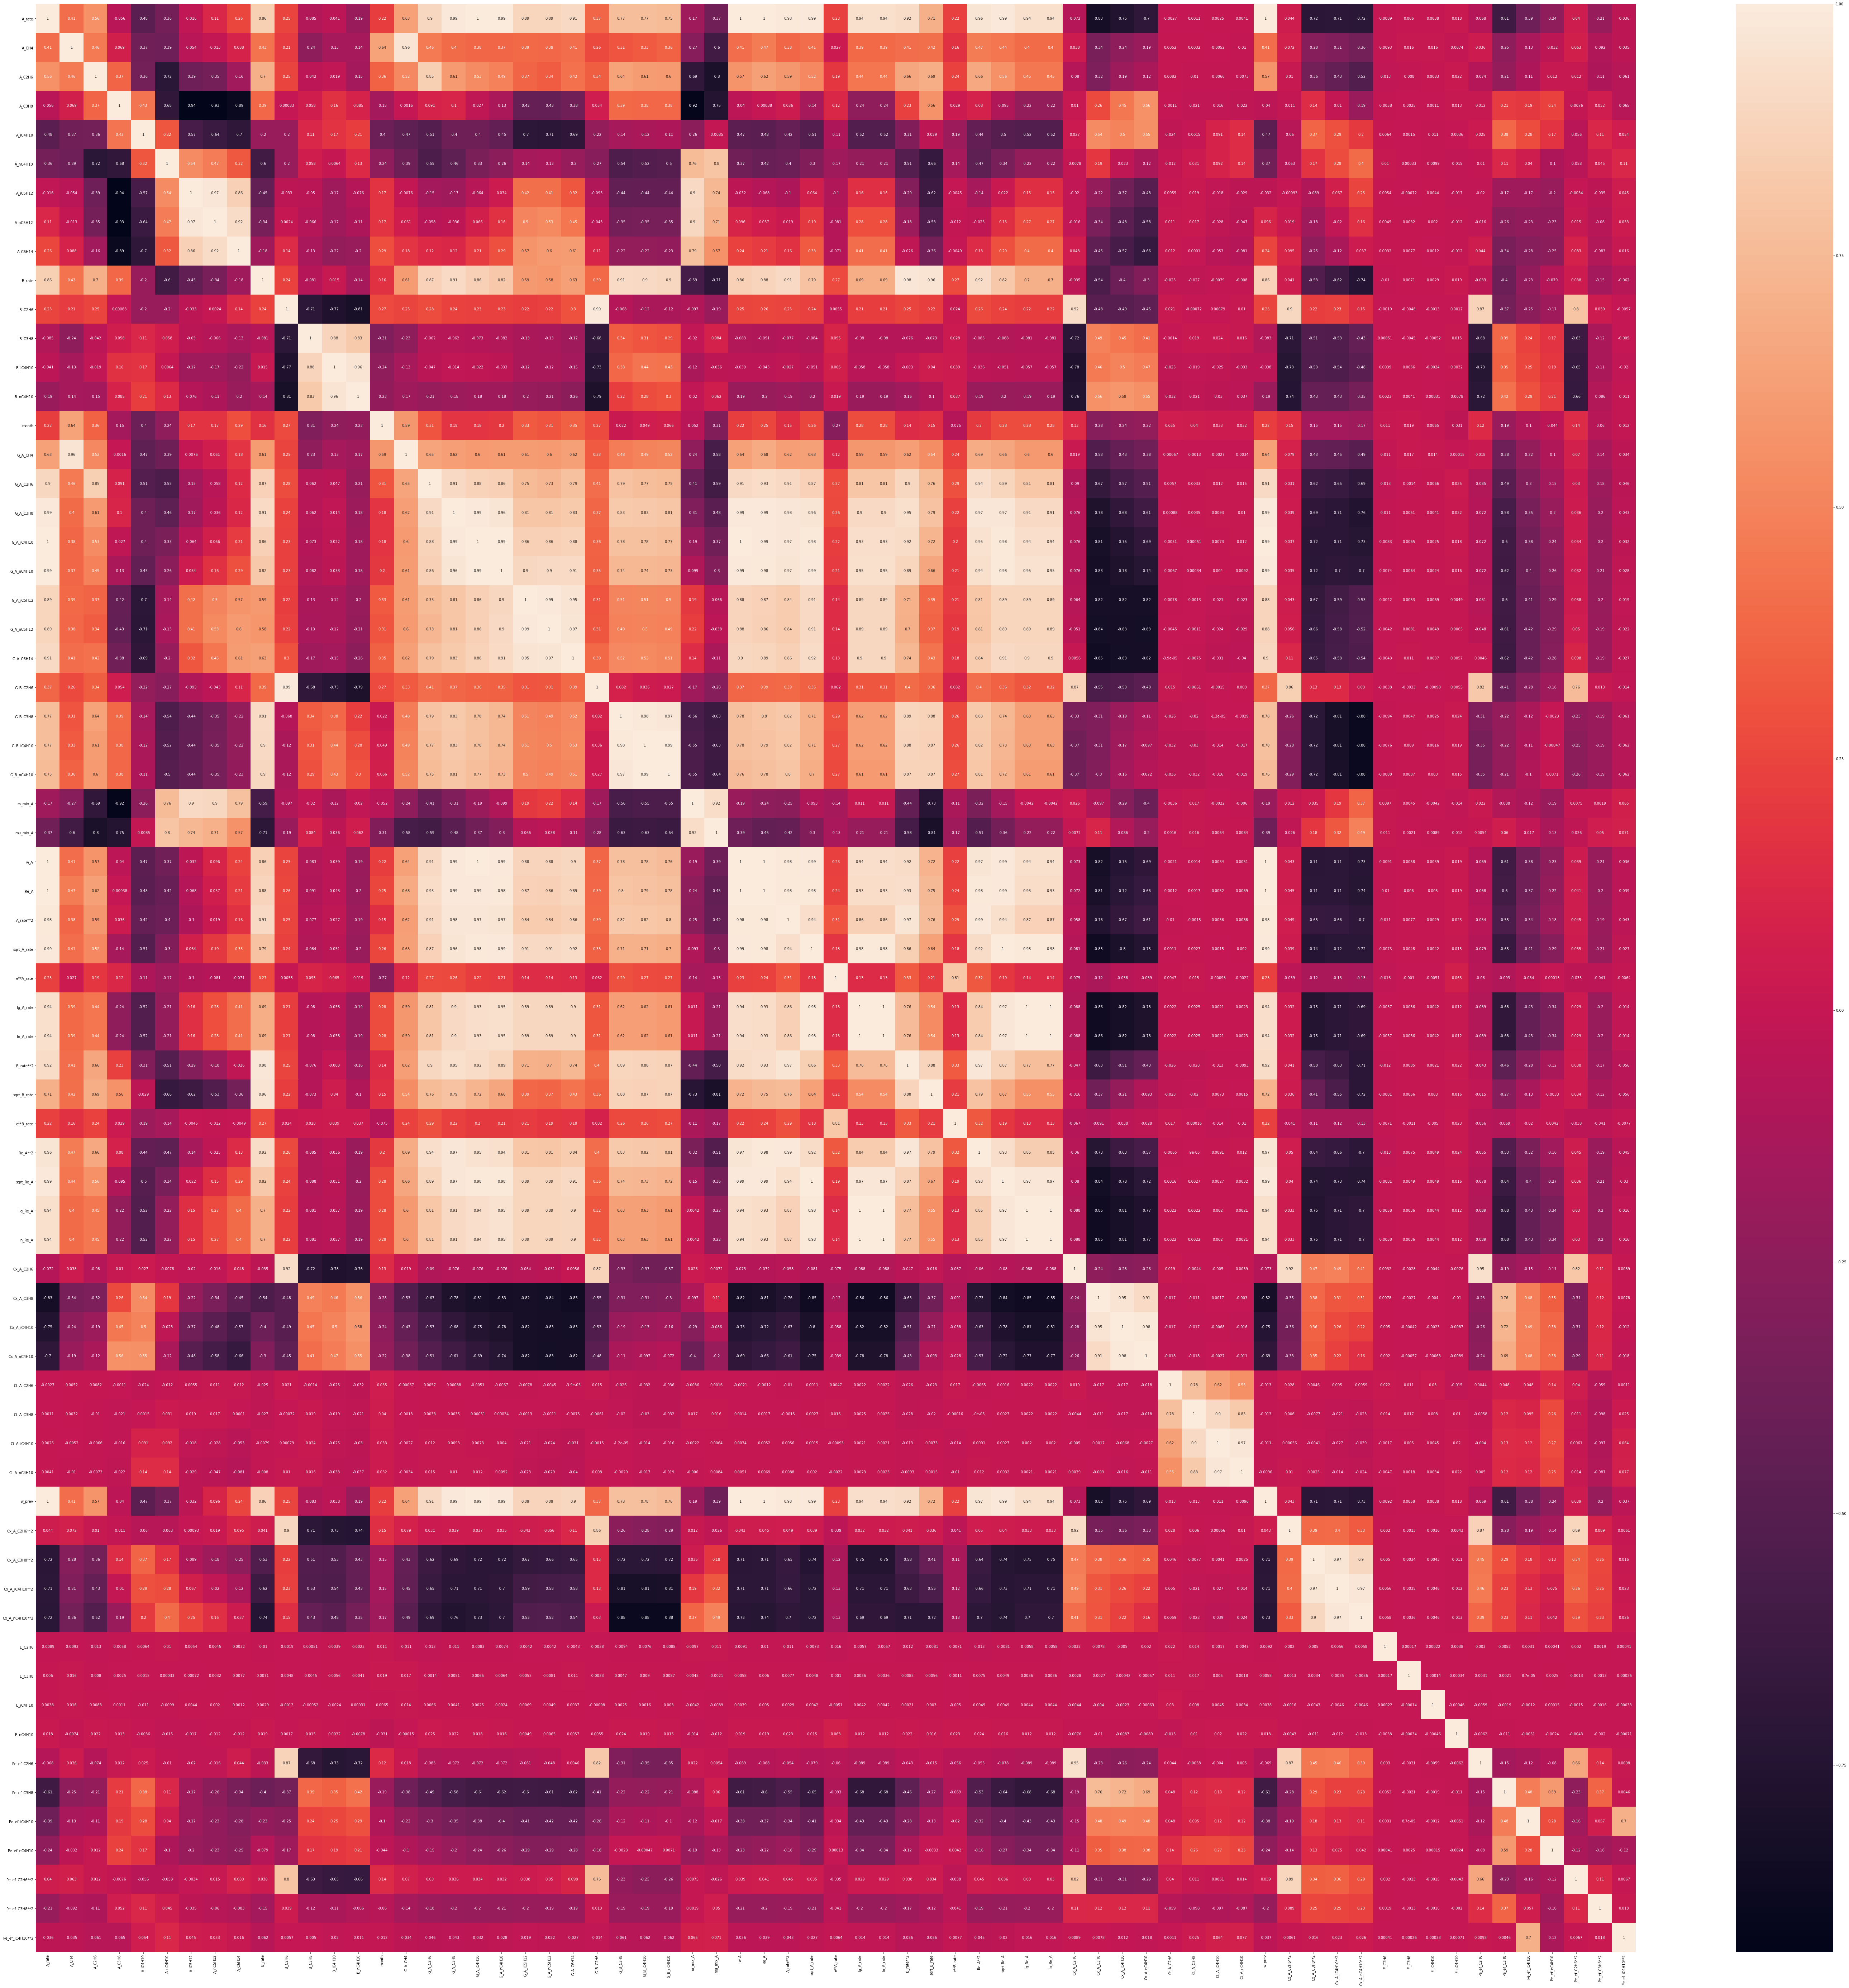

In [82]:
plt.figure(figsize=(100,100))
sns.heatmap(data.corr(), annot=True)

In [83]:
corrMatrix = pd.DataFrame()
corrMatrix['x'] = x.columns
corrMatrix['G_B_C2H6'] = np.array(x.corrwith(data['G_B_C2H6']))
corrMatrix['G_B_C3H8'] = np.array(x.corrwith(data['G_B_C3H8']))
corrMatrix['G_B_iC4H10'] = np.array(x.corrwith(data['G_B_iC4H10']))
corrMatrix['G_B_nC4H10'] = np.array(x.corrwith(data['G_B_nC4H10']))
corrMatrix['B_C2H6'] = np.array(x.corrwith(data['B_C2H6']))
corrMatrix['B_C3H8'] = np.array(x.corrwith(data['B_C3H8']))
corrMatrix['B_iC4H10'] = np.array(x.corrwith(data['B_iC4H10']))
corrMatrix['B_nC4H10'] = np.array(x.corrwith(data['B_nC4H10']))

In [84]:
corrMatrix

x  G_B_C2H6  G_B_C3H8  G_B_iC4H10  G_B_nC4H10    B_C2H6  \
0            A_rate  0.373062  0.772160    0.769557    0.754458  0.246244   
1             A_CH4  0.259183  0.306192    0.329544    0.359226  0.207378   
2            A_C2H6  0.342121  0.643350    0.613653    0.603821  0.251153   
3            A_C3H8  0.053869  0.391475    0.381971    0.382209  0.000830   
4          A_iC4H10 -0.224206 -0.136470   -0.123360   -0.111565 -0.198109   
5          A_nC4H10 -0.274719 -0.542046   -0.515782   -0.504799 -0.197997   
6          A_iC5H12 -0.092621 -0.444495   -0.441769   -0.438796 -0.032940   
7          A_nC5H12 -0.042701 -0.354116   -0.347385   -0.351375  0.002387   
8           A_C6H14  0.106151 -0.222421   -0.218151   -0.228927  0.135181   
9            B_rate  0.390611  0.909309    0.904709    0.901108  0.241599   
10            month  0.270496  0.022174    0.048750    0.066246  0.271156   
11          G_A_CH4  0.332500  0.475380    0.494667    0.515933  0.249542   
12         G_A_C2H6  0.405335  0.791580    0.769113    0.752699  0.280772   
13         G_A_C3H8  0.372604  0.833090    0.825360    0.808524  0.238129   
14       G_A_iC4H10  0.358927  0.784008    0.783301    0.768466  0.230895   
15       G_A_nC4H10  0.350414  0.737686    0.741088    0.727890  0.227936   
16       G_A_iC5H12  0.309099  0.506054    0.509741    0.503043  0.218830   
17       G_A_nC5H12  0.312049  0.491766    0.499288    0.489000  0.223375   
18        G_A_C6H14  0.389654  0.521035    0.527182    0.511926  0.299808   
19         ro_mix_A -0.174788 -0.563633   -0.548848   -0.550121 -0.096649   
20         mu_mix_A -0.280651 -0.634179   -0.628200   -0.637953 -0.188032   
21              w_A  0.374781  0.780140    0.776809    0.761623  0.246962   
22             Re_A  0.387054  0.796078    0.791693    0.778271  0.257117   
23        A_rate**2  0.388609  0.821597    0.816739    0.801420  0.249682   
24      sqrt_A_rate  0.350225  0.712272    0.710464    0.695455  0.235373   
25        e**A_rate  0.062494  0.291161    0.273661    0.265548  0.005453   
26        lg_A_rate  0.312599  0.621353    0.620609    0.605757  0.214050   
27        ln_A_rate  0.312599  0.621353    0.620609    0.605757  0.214050   
28        B_rate**2  0.396020  0.888111    0.882649    0.874497  0.245947   
29      sqrt_B_rate  0.355517  0.875877    0.871273    0.873649  0.215679   
30        e**B_rate  0.082039  0.261746    0.262148    0.274438  0.024049   
31          Re_A**2  0.403279  0.832584    0.824669    0.811693  0.263306   
32        sqrt_Re_A  0.361466  0.735520    0.732789    0.718814  0.243397   
33          lg_Re_A  0.316158  0.629393    0.628540    0.613908  0.216468   
34          ln_Re_A  0.316158  0.629393    0.628540    0.613908  0.216468   
35        Cx_A_C2H6  0.871962 -0.332783   -0.371935   -0.373524  0.923508   
36        Cx_A_C3H8 -0.547113 -0.308458   -0.312293   -0.296425 -0.484991   
37      Cx_A_iC4H10 -0.527872 -0.190953   -0.172729   -0.155392 -0.486849   
38      Cx_A_nC4H10 -0.481110 -0.113225   -0.096605   -0.071897 -0.451999   
39        Ct_A_C2H6  0.014646 -0.025692   -0.032020   -0.035936  0.020528   
40        Ct_A_C3H8 -0.006143 -0.020330   -0.029605   -0.031645 -0.000724   
41      Ct_A_iC4H10 -0.001539 -0.000012   -0.013915   -0.016311  0.000791   
42      Ct_A_nC4H10  0.007994 -0.002925   -0.016612   -0.019389  0.010420   
43           w_prev  0.374790  0.780408    0.777247    0.762108  0.246900   
44     Cx_A_C2H6**2  0.855956 -0.256624   -0.281649   -0.289920  0.896749   
45     Cx_A_C3H8**2  0.125177 -0.717097   -0.721939   -0.716239  0.218354   
46   Cx_A_iC4H10**2  0.126355 -0.807705   -0.807507   -0.805911  0.232727   
47   Cx_A_nC4H10**2  0.030010 -0.879537   -0.878190   -0.878954  0.149193   
48           E_C2H6 -0.003759 -0.009424   -0.007569   -0.008766 -0.001885   
49           E_C3H8 -0.003342  0.004739    0.009043    0.008726 -0.004833   
50         E_iC4H10 -0.000983  0.002524    0.001577    0.002999 -0.001292   
51         E_n

In [85]:
for i in corrMatrix.drop(labels='x', axis=1).columns:
    print(i + ' = ' , sum(corrMatrix[i].apply(abs)))

G_B_C2H6 =  16.60137394071271
G_B_C3H8 =  26.185391660188717
G_B_iC4H10 =  26.19722807156565
G_B_nC4H10 =  25.93377663056532
B_C2H6 =  13.527286191363652
B_C3H8 =  10.02059978739588
B_iC4H10 =  9.711052110023271
B_nC4H10 =  12.679403156332203


In [86]:
corrMatrix[(corrMatrix['G_B_C2H6'] > 0.3) | (corrMatrix['G_B_C2H6'] < -0.3)][['x', 'G_B_C2H6']]

x  G_B_C2H6
0          A_rate  0.373062
2          A_C2H6  0.342121
9          B_rate  0.390611
11        G_A_CH4  0.332500
12       G_A_C2H6  0.405335
13       G_A_C3H8  0.372604
14     G_A_iC4H10  0.358927
15     G_A_nC4H10  0.350414
16     G_A_iC5H12  0.309099
17     G_A_nC5H12  0.312049
18      G_A_C6H14  0.389654
21            w_A  0.374781
22           Re_A  0.387054
23      A_rate**2  0.388609
24    sqrt_A_rate  0.350225
26      lg_A_rate  0.312599
27      ln_A_rate  0.312599
28      B_rate**2  0.396020
29    sqrt_B_rate  0.355517
31        Re_A**2  0.403279
32      sqrt_Re_A  0.361466
33        lg_Re_A  0.316158
34        ln_Re_A  0.316158
35      Cx_A_C2H6  0.871962
36      Cx_A_C3H8 -0.547113
37    Cx_A_iC4H10 -0.527872
38    Cx_A_nC4H10 -0.481110
43         w_prev  0.374790
44   Cx_A_C2H6**2  0.855956
52     Pe_ef_C2H6  0.824877
53     Pe_ef_C3H8 -0.414056
56  Pe_ef_C2H6**2  0.760490

In [87]:
d = data[['G_A_C2H6','Re_A**2','Cx_A_C2H6','Cx_A_C2H6**2','Pe_ef_C2H6','Pe_ef_C2H6**2','G_B_C2H6']]

In [88]:
#запись DataFrame в файл
d.to_csv('train_data_C2H6.csv', sep=',', header=True, index=False)

In [89]:
corrMatrix[(corrMatrix['G_B_C3H8'] > 0.3) | (corrMatrix['G_B_C3H8'] < -0.3)][['x', 'G_B_C3H8']]

x  G_B_C3H8
0           A_rate  0.772160
1            A_CH4  0.306192
2           A_C2H6  0.643350
3           A_C3H8  0.391475
5         A_nC4H10 -0.542046
6         A_iC5H12 -0.444495
7         A_nC5H12 -0.354116
9           B_rate  0.909309
11         G_A_CH4  0.475380
12        G_A_C2H6  0.791580
13        G_A_C3H8  0.833090
14      G_A_iC4H10  0.784008
15      G_A_nC4H10  0.737686
16      G_A_iC5H12  0.506054
17      G_A_nC5H12  0.491766
18       G_A_C6H14  0.521035
19        ro_mix_A -0.563633
20        mu_mix_A -0.634179
21             w_A  0.780140
22            Re_A  0.796078
23       A_rate**2  0.821597
24     sqrt_A_rate  0.712272
26       lg_A_rate  0.621353
27       ln_A_rate  0.621353
28       B_rate**2  0.888111
29     sqrt_B_rate  0.875877
31         Re_A**2  0.832584
32       sqrt_Re_A  0.735520
33         lg_Re_A  0.629393
34         ln_Re_A  0.629393
35       Cx_A_C2H6 -0.332783
36       Cx_A_C3H8 -0.308458
43          w_prev  0.780408
45    Cx_A_C3H8**2 -0.717097
46  Cx_A_iC4H10**2 -0.807705
47  Cx_A_nC4H10**2 -0.879537
52      Pe_ef_C2H6 -0.313928

In [90]:
d = data[['B_rate','G_A_C3H8','Re_A**2','w_prev','Cx_A_C3H8**2','Cx_A_iC4H10**2','Cx_A_nC4H10**2','G_B_C3H8']]

In [91]:
#запись DataFrame в файл
d.to_csv('train_data_C3H8.csv', sep=',', header=True, index=False)

In [92]:
corrMatrix[(corrMatrix['G_B_iC4H10'] > 0.3) | (corrMatrix['G_B_iC4H10'] < -0.3)][['x', 'G_B_iC4H10']]

x  G_B_iC4H10
0           A_rate    0.769557
1            A_CH4    0.329544
2           A_C2H6    0.613653
3           A_C3H8    0.381971
5         A_nC4H10   -0.515782
6         A_iC5H12   -0.441769
7         A_nC5H12   -0.347385
9           B_rate    0.904709
11         G_A_CH4    0.494667
12        G_A_C2H6    0.769113
13        G_A_C3H8    0.825360
14      G_A_iC4H10    0.783301
15      G_A_nC4H10    0.741088
16      G_A_iC5H12    0.509741
17      G_A_nC5H12    0.499288
18       G_A_C6H14    0.527182
19        ro_mix_A   -0.548848
20        mu_mix_A   -0.628200
21             w_A    0.776809
22            Re_A    0.791693
23       A_rate**2    0.816739
24     sqrt_A_rate    0.710464
26       lg_A_rate    0.620609
27       ln_A_rate    0.620609
28       B_rate**2    0.882649
29     sqrt_B_rate    0.871273
31         Re_A**2    0.824669
32       sqrt_Re_A    0.732789
33         lg_Re_A    0.628540
34         ln_Re_A    0.628540
35       Cx_A_C2H6   -0.371935
36       Cx_A_C3H8   -0.312293
43          w_prev    0.777247
45    Cx_A_C3H8**2   -0.721939
46  Cx_A_iC4H10**2   -0.807507
47  Cx_A_nC4H10**2   -0.878190
52      Pe_ef_C2H6   -0.351531

In [93]:
d = data[['B_rate','G_A_C3H8','G_A_iC4H10','Re_A**2','w_prev','Cx_A_iC4H10**2','Cx_A_nC4H10**2','G_B_iC4H10']]

In [94]:
#запись DataFrame в файл
d.to_csv('train_data_iC4H10.csv', sep=',', header=True, index=False)

In [95]:
corrMatrix[(corrMatrix['G_B_nC4H10'] > 0.3) | (corrMatrix['G_B_nC4H10'] < -0.3)][['x','G_B_nC4H10']] 

x  G_B_nC4H10
0           A_rate    0.754458
1            A_CH4    0.359226
2           A_C2H6    0.603821
3           A_C3H8    0.382209
5         A_nC4H10   -0.504799
6         A_iC5H12   -0.438796
7         A_nC5H12   -0.351375
9           B_rate    0.901108
11         G_A_CH4    0.515933
12        G_A_C2H6    0.752699
13        G_A_C3H8    0.808524
14      G_A_iC4H10    0.768466
15      G_A_nC4H10    0.727890
16      G_A_iC5H12    0.503043
17      G_A_nC5H12    0.489000
18       G_A_C6H14    0.511926
19        ro_mix_A   -0.550121
20        mu_mix_A   -0.637953
21             w_A    0.761623
22            Re_A    0.778271
23       A_rate**2    0.801420
24     sqrt_A_rate    0.695455
26       lg_A_rate    0.605757
27       ln_A_rate    0.605757
28       B_rate**2    0.874497
29     sqrt_B_rate    0.873649
31         Re_A**2    0.811693
32       sqrt_Re_A    0.718814
33         lg_Re_A    0.613908
34         ln_Re_A    0.613908
35       Cx_A_C2H6   -0.373524
43          w_prev    0.762108
45    Cx_A_C3H8**2   -0.716239
46  Cx_A_iC4H10**2   -0.805911
47  Cx_A_nC4H10**2   -0.878954
52      Pe_ef_C2H6   -0.353422

In [96]:
d = data[['B_rate','G_A_C3H8','G_A_nC4H10','Re_A**2','w_prev','Cx_A_iC4H10**2','Cx_A_nC4H10**2','G_B_nC4H10']]

In [97]:
#запись DataFrame в файл
d.to_csv('train_data_nC4H10.csv', sep=',', header=True, index=False)

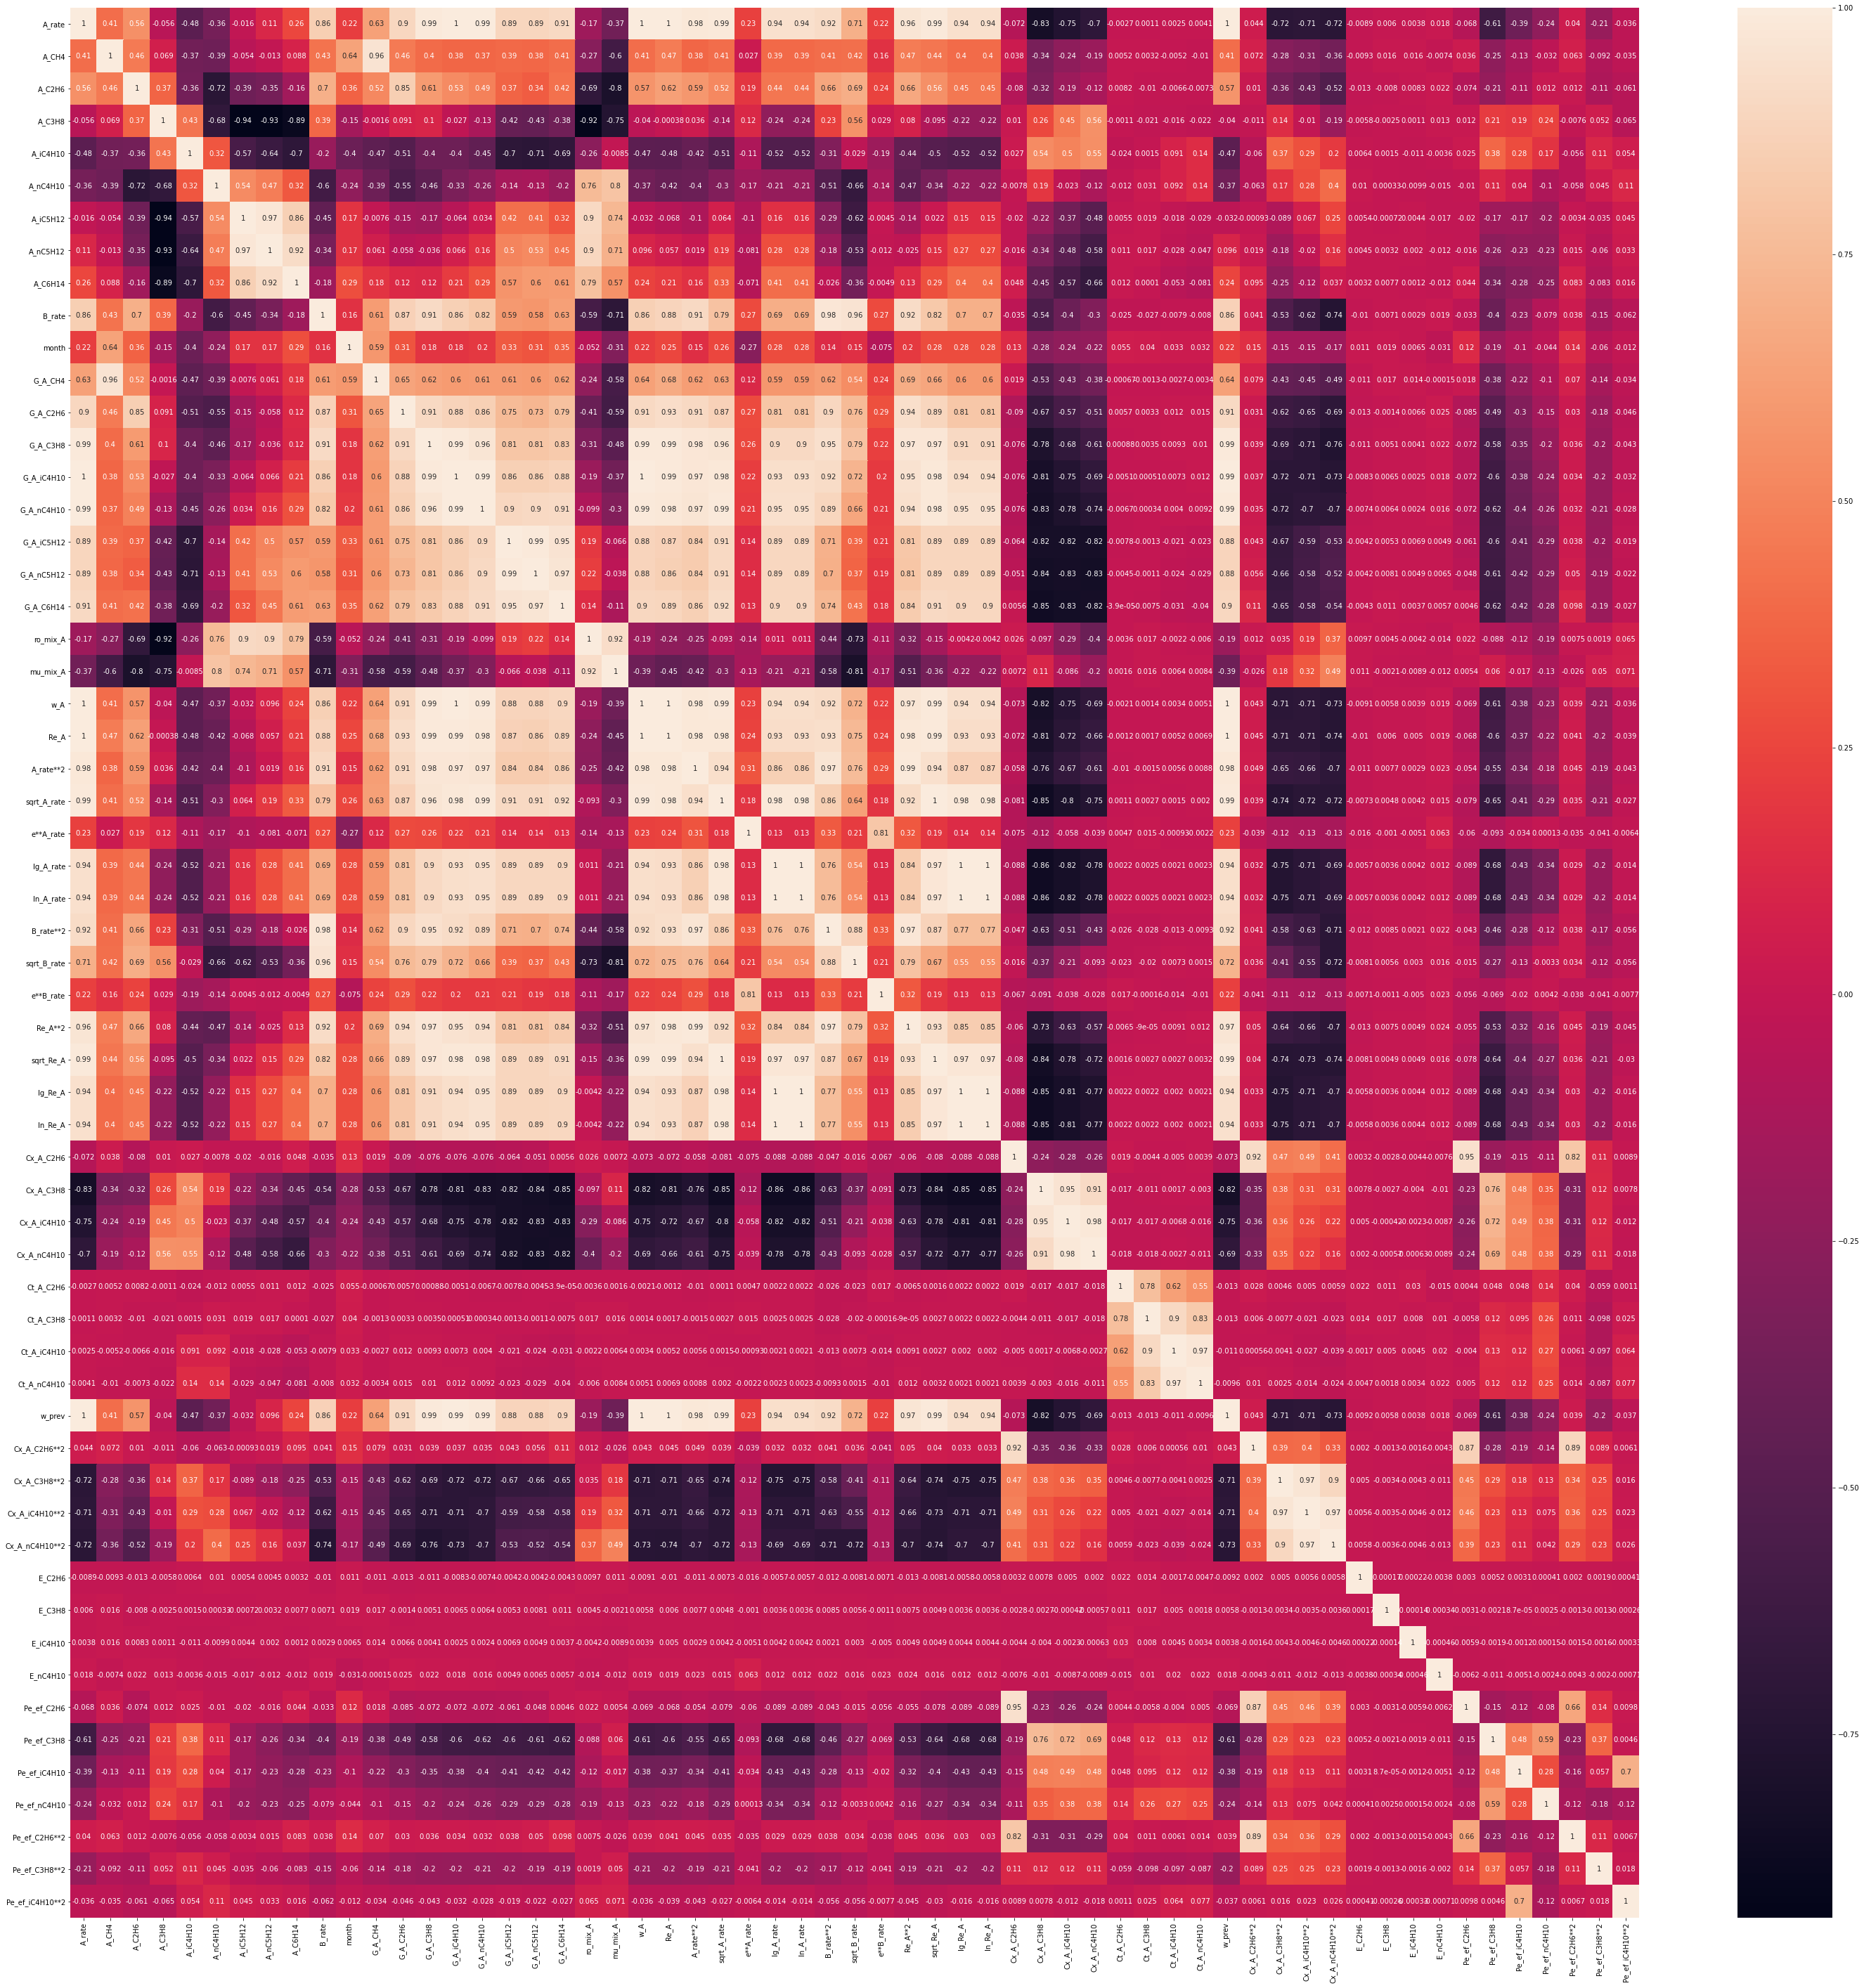

In [98]:
plt.figure(figsize=(50,50))
sns.heatmap(x.corr(), annot=True)

In [99]:
#запись DataFrame в файл
data.to_csv('train_data.csv', sep=',', header=True, index=False)

1. ГОСТ 28656-90
2. "Природные и искусственные газы. Учебник для техникумов. 4-е изд. 1978 г" Рябцев Н.И.
3. Wikipedia

In [100]:
#!cat train_data.csv

## Обработаем test_features

In [101]:
monthList =[]
for i in test_features['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [102]:
test_features['month'] = monthList

In [103]:
test_features = test_features.ffill(axis = 0)
test_features.isnull().sum()

timestamp    0
A_rate       0
A_CH4        0
A_C2H6       0
A_C3H8       0
A_iC4H10     0
A_nC4H10     0
A_iC5H12     0
A_nC5H12     0
A_C6H14      0
B_rate       0
month        0
dtype: int64

In [104]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  month  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009      5  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833      5  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268      5  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744      5  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447      5  
...         ...        ...       ...       ...       ...        ...    ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026      7  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451      7  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878      7  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867      7  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667      7  

[3984 rows x 12 columns]

In [105]:
test_features_prev = test_features
test_features = test_features.rolling(25, min_periods=0).mean()

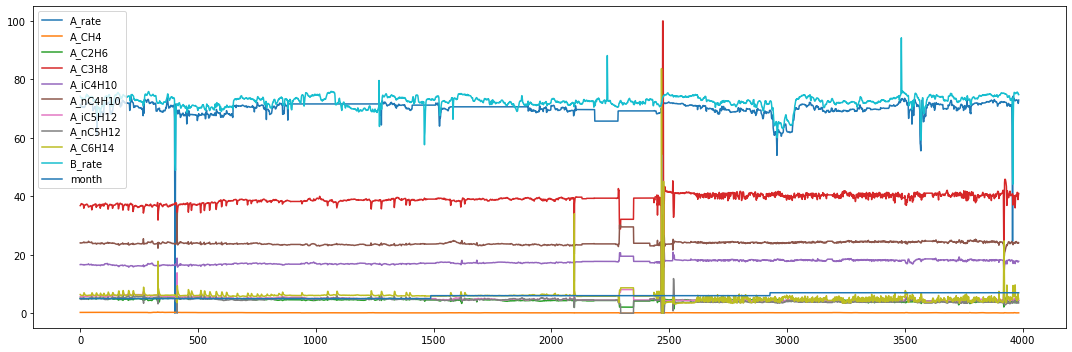

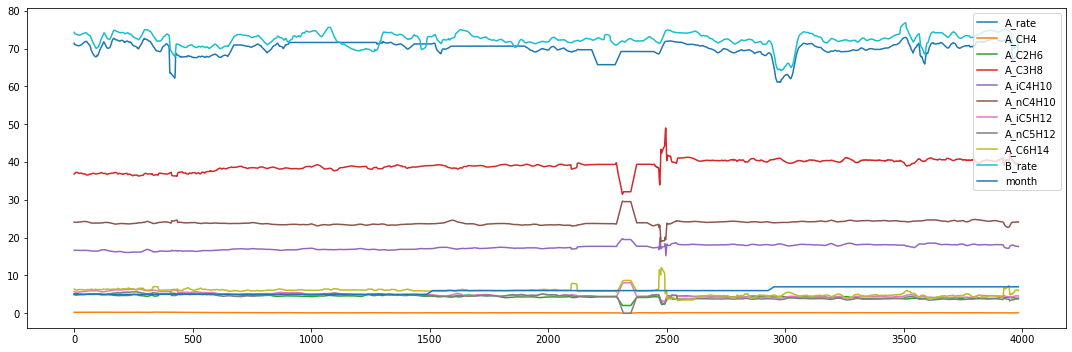

In [106]:
plt.rcParams["figure.figsize"] = (15,5)
test_features_prev[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
test_features[:].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [107]:
test_features['G_A_CH4'] = test_features['A_rate'] * test_features['A_CH4'] / 100
test_features['G_A_C2H6'] = test_features['A_rate'] * test_features['A_C2H6'] / 100
test_features['G_A_C3H8'] = test_features['A_rate'] * test_features['A_C3H8'] / 100
test_features['G_A_iC4H10'] = test_features['A_rate'] * test_features['A_iC4H10'] / 100
test_features['G_A_nC4H10'] = test_features['A_rate'] * test_features['A_nC4H10'] / 100
test_features['G_A_iC5H12'] = test_features['A_rate'] * test_features['A_iC5H12'] / 100
test_features['G_A_nC5H12'] = test_features['A_rate'] * test_features['A_nC5H12'] / 100
test_features['G_A_C6H14'] = test_features['A_rate'] * test_features['A_C6H14'] / 100

In [108]:
test_features['ro_mix_A'] = ((test_features['A_CH4'] / 100 / ro_CH4) + (test_features['A_C2H6'] / 100 / ro_C2H6) 
                  + (test_features['A_C3H8'] / 100 / ro_C3H8) + (test_features['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (test_features['A_nC4H10'] / 100 / ro_nC4H10) + (test_features['A_iC5H12'] / 100 / ro_iC5H12)
                  + (test_features['A_nC5H12'] / 100 / ro_nC5H12) + (test_features['A_C6H14'] / 100 / ro_C6H14))**-1

In [109]:
test_features['mu_mix_A'] = (((test_features['A_CH4'] / 100) * (test_features['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((test_features['A_C2H6'] / 100) * (test_features['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((test_features['A_C3H8'] / 100) * (test_features['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((test_features['A_iC4H10'] / 100) * (test_features['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((test_features['A_nC4H10'] / 100) * (test_features['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((test_features['A_iC5H12'] / 100) * (test_features['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((test_features['A_nC5H12'] / 100) * (test_features['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((test_features['A_C6H14'] / 100) * (test_features['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [110]:
test_features['w_A'] = (4*test_features['A_rate']*0.278)/(3.14*test_features['ro_mix_A']*0.16)
test_features['Re_A'] = (4*test_features['A_rate']*0.278)/(3.14*0.4*test_features['mu_mix_A'])

In [111]:
test_features['A_rate**2'] = test_features['A_rate']**2
test_features['sqrt_A_rate'] = test_features['A_rate'].apply(m.sqrt)
test_features['e**A_rate'] = test_features['A_rate'].apply(m.exp)
test_features['lg_A_rate'] = test_features['A_rate'].apply(m.log10)
test_features['ln_A_rate'] = test_features['A_rate'].apply(m.log)

test_features['B_rate**2'] = test_features['B_rate']**2
test_features['sqrt_B_rate'] = test_features['B_rate'].apply(m.sqrt)
test_features['e**B_rate'] = test_features['B_rate'].apply(m.exp)


test_features['Re_A**2'] = test_features['Re_A']**2
test_features['sqrt_Re_A'] = test_features['Re_A'].apply(m.sqrt)

test_features['lg_Re_A'] = test_features['Re_A'].apply(m.log10)
test_features['ln_Re_A'] = test_features['Re_A'].apply(m.log)

In [112]:
test_features

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.428342  0.267832  5.135159  36.816480  16.632260  24.062587   
1     71.176730  0.268148  5.142402  36.842752  16.642065  24.066193   
2     71.115060  0.268979  5.146473  36.920156  16.665032  24.079513   
3     71.079396  0.270545  5.167520  37.036162  16.669608  24.065133   
4     71.059532  0.271448  5.182303  37.118647  16.668459  24.052754   
...         ...       ...       ...        ...        ...        ...   
3979  68.304891  0.119512  4.025974  39.598743  17.690124  24.125104   
3980  68.632519  0.119121  4.015950  39.536427  17.662900  24.111860   
3981  69.834182  0.118976  4.002939  39.496366  17.645730  24.110723   
3982  71.735081  0.119308  3.991399  39.479565  17.635418  24.113394   
3983  72.741092  0.120283  3.998443  39.627151  17.650079  24.115738   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate  month   G_A_CH4  G_A_C2H6  \
0     5.696004  4.939430  6.395286  74.273009    5.0  0.191308  3.667959   
1     5.686194  4.925651  6.371121  74.167421    5.0  0.190859  3.660194   
2     5.649087  4.886606  6.328293  74.063703    5.0  0.191285  3.659918   
3     5.615526  4.847676  6.271631  73.985463    5.0  0.192301  3.673042   
4     5.597400  4.823918  6.228729  73.928060    5.0  0.192890  3.682521   
...        ...       ...       ...        ...    ...       ...       ...   
3979  4.584583  3.754411  6.050439  71.147451    7.0  0.081633  2.749937   
3980  4.598629  3.773469  6.130404  71.256112    7.0  0.081756  2.756247   
3981  4.610501  3.788795  6.174530  71.607384    7.0  0.083086  2.795420   
3982  4.617921  3.798771  6.192439  72.582642    7.0  0.085586  2.863233   
3983  4.596188  3.772929  6.066762  73.808644    7.0  0.087495  2.908511   

       G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  \
0     26.297401   11.880148   17.187507    4.068561    3.528153   4.568047   
1     26.223466   11.845278   17.129529    4.047247    3.505918   4.534756   
2     26.255791   11.851348   17.124160    4.017352    3.475113   4.500369   
3     26.325080   11.848657   17.105351    3.991482    3.445699   4.457838   
4     26.376337   11.844529   17.091774    3.977487    3.427853   4.426106   
...         ...         ...         ...         ...         ...        ...   
3979  27.047878   12.083220   16.478626    3.131494    2.564446   4.132746   
3980  27.134846   12.122493   16.548577    3.156155    2.589827   4.207451   
3981  27.581964   12.322751   16.837526    3.219705    2.645874   4.311932   
3982  28.320698   12.650781   17.297763    3.312669    2.725052   4.442151   
3983  28.825223   12.838860   17.542051    3.343317    2.744470   4.413029   

        ro_mix_A  mu_mix_A       w_A           Re_A    A_rate**2  sqrt_A_rate  \
0     562.574167  0.000151  0.281026  419019.690291  5102.008078     8.451529   
1     562.513894  0.000151  0.280066  417716.031332  5066.126880     8.436630   
2     562.390951  0.000151  0.279884  417677.086653  5057.351702     8.432975   
3     562.189616  0.000151  0.279844  418092.480177  5052.280554     8.430860   
4     562.050079  0.000150  0.279835  418391.849005  5049.457156     8.429682   
...          ...       ...       ...            ...          ...          ...   
3979  563.020705  0.000159  0.268524  380844.777764  4665.558100     8.264677   
3980  563.157117  0.000159  0.269746  382368.259444  4710.422705     8.284475   
3981  563.259337  0.000159  0.274419  388821.338979  4876.812974     8.356685   
3982  563.319351  0.000159  0.281859  399288.163412  5145.921826     8.469656   
3983  563.101145  0.000159  0.285923  405435.375734  5291.266535     8.528839   

         e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  sqrt_B_rate  \
0     1.049385e+31   1.853871   4.268695  5516.479837     8.618179   
1     8.159453e+30   1.852338   4.265166  5500.806318     8.612051   
2     7.671459e+30   1.851962   4.264299  5485.432125     8.606027   
3     7.402689e+30   1.851744   4.263798 

In [113]:
last_line

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
5797  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
5797  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  \
5797  24.517125      4  0.213048  3.569881  25.479712   11.724163   17.183164   

      G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  G_B_iC4H10  \
5797    4.152003    3.661481   4.466263  3.648088  25.981607   11.638576   

      G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A    A_rate**2  \
5797   17.799919  563.169703   0.00015  0.277036  415477.749614  4968.683371   

      sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
5797     8.395766  4.101429e+30   1.848121   4.255455  5271.047629   

      sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A  \
5797      8.52068  3.393436e+31  1.726218e+11  644.575635  5.618548   

        ln_Re_A  Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  \
5797  12.937184   0.068488   0.526622    -0.091283     0.596711  -0.000561   

      Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10    w_prev  Cx_A_C2H6**2  \
5797   0.055675      0.01638     0.016305  0.276608      0.004691   

      Cx_A_C3H8**2  Cx_A_iC4H10**2  Cx_A_nC4H10**2    E_C2H6    E_C3H8  \
5797      0.277331        0.008333        0.356064  3.919092  0.726001   

      E_iC4H10  E_nC4H10  Pe_ef_C2H6  Pe_ef_C3H8  Pe_ef_iC4H10  Pe_ef_nC4H10  \
5797 -1.064438  0.509348     0.07058    0.381002     -0.259863      0.543063   

      Pe_ef_C2H6**2  Pe_ef_C3H8**2  Pe_ef_iC4H10**2  
5797       0.004981       0.145163         0.067529

In [114]:
test_features = pd.concat([last_line,test_features], axis=0)
test_features = test_features.reset_index(drop=True)

In [115]:
test_features

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   
1     71.428342  0.267832  5.135159  36.816480  16.632260  24.062587   
2     71.176730  0.268148  5.142402  36.842752  16.642065  24.066193   
3     71.115060  0.268979  5.146473  36.920156  16.665032  24.079513   
4     71.079396  0.270545  5.167520  37.036162  16.669608  24.065133   
...         ...       ...       ...        ...        ...        ...   
3980  68.304891  0.119512  4.025974  39.598743  17.690124  24.125104   
3981  68.632519  0.119121  4.015950  39.536427  17.662900  24.111860   
3982  69.834182  0.118976  4.002939  39.496366  17.645730  24.110723   
3983  71.735081  0.119308  3.991399  39.479565  17.635418  24.113394   
3984  72.741092  0.120283  3.998443  39.627151  17.650079  24.115738   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   
1     5.696004  4.939430  6.395286  74.273009       NaN        NaN        NaN   
2     5.686194  4.925651  6.371121  74.167421       NaN        NaN        NaN   
3     5.649087  4.886606  6.328293  74.063703       NaN        NaN        NaN   
4     5.615526  4.847676  6.271631  73.985463       NaN        NaN        NaN   
...        ...       ...       ...        ...       ...        ...        ...   
3980  4.584583  3.754411  6.050439  71.147451       NaN        NaN        NaN   
3981  4.598629  3.773469  6.130404  71.256112       NaN        NaN        NaN   
3982  4.610501  3.788795  6.174530  71.607384       NaN        NaN        NaN   
3983  4.617921  3.798771  6.192439  72.582642       NaN        NaN        NaN   
3984  4.596188  3.772929  6.066762  73.808644       NaN        NaN        NaN   

       B_nC4H10  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  \
0     24.517125    4.0  0.213048  3.569881  25.479712   11.724163   17.183164   
1           NaN    5.0  0.191308  3.667959  26.297401   11.880148   17.187507   
2           NaN    5.0  0.190859  3.660194  26.223466   11.845278   17.129529   
3           NaN    5.0  0.191285  3.659918  26.255791   11.851348   17.124160   
4           NaN    5.0  0.192301  3.673042  26.325080   11.848657   17.105351   
...         ...    ...       ...       ...        ...         ...         ...   
3980        NaN    7.0  0.081633  2.749937  27.047878   12.083220   16.478626   
3981        NaN    7.0  0.081756  2.756247  27.134846   12.122493   16.548577   
3982        NaN    7.0  0.083086  2.795420  27.581964   12.322751   16.837526   
3983        NaN    7.0  0.085586  2.863233  28.320698   12.650781   17.297763   
3984        NaN    7.0  0.087495  2.908511  28.825223   12.838860   17.542051   

      G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  G_B_iC4H10  \
0       4.152003    3.661481   4.466263  3.648088  25.981607   11.638576   
1       4.068561    3.528153   4.568047       NaN        NaN         NaN   
2       4.047247    3.505918   4.534756       NaN        NaN         NaN   
3       4.017352    3.475113   4.500369       NaN        NaN         NaN   
4       3.991482    3.445699   4.457838       NaN        NaN         NaN   
...          ...         ...        ...       ...        ...         ...   
3980    3.131494    2.564446   4.132746       NaN        NaN         NaN   
3981    3.156155    2.589827   4.207451       NaN        NaN         NaN   
3982    3.219705    2.645874   4.311932       NaN        NaN         NaN   
3983    3.312669    2.725052   4.442151       NaN        NaN         NaN   
3984    3.343317    2.744470   4.413029       NaN        NaN         NaN   

      G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A    A_rate**2  \
0      17.799919  563.169703  0.000150  0.277036  415477.749614  4968.683371   
1            NaN  562.574167  0.000151  0.281026  419019.690291  5102.008078   
2            NaN  562.513894  0.000151  0.280

In [116]:
test_features.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10', 'ro_mix_A',
       'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate', 'e**A_rate',
       'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate', 'e**B_rate',
       'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6', 'Cx_A_C3H8',
       'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8', 'Ct_A_iC4H10',
       'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
      dtype='object')

In [117]:
test_features = test_features.drop(labels=['B_C2H6','B_C3H8', 'B_iC4H10', 'B_nC4H10','E_C2H6', 'E_C3H8',
                                           'E_iC4H10','E_nC4H10', 'Pe_ef_C3H8', 'Pe_ef_iC4H10',
                                           'Ct_A_C2H6', 'Ct_A_C3H8','Ct_A_iC4H10', 'Ct_A_nC4H10',
                                           'Pe_ef_nC4H10','Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
                                            axis=1)

In [118]:
test_features

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   
1     71.428342  0.267832  5.135159  36.816480  16.632260  24.062587   
2     71.176730  0.268148  5.142402  36.842752  16.642065  24.066193   
3     71.115060  0.268979  5.146473  36.920156  16.665032  24.079513   
4     71.079396  0.270545  5.167520  37.036162  16.669608  24.065133   
...         ...       ...       ...        ...        ...        ...   
3980  68.304891  0.119512  4.025974  39.598743  17.690124  24.125104   
3981  68.632519  0.119121  4.015950  39.536427  17.662900  24.111860   
3982  69.834182  0.118976  4.002939  39.496366  17.645730  24.110723   
3983  71.735081  0.119308  3.991399  39.479565  17.635418  24.113394   
3984  72.741092  0.120283  3.998443  39.627151  17.650079  24.115738   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate  month   G_A_CH4  G_A_C2H6  \
0     5.890294  5.194408  6.336124  72.601981    4.0  0.213048  3.569881   
1     5.696004  4.939430  6.395286  74.273009    5.0  0.191308  3.667959   
2     5.686194  4.925651  6.371121  74.167421    5.0  0.190859  3.660194   
3     5.649087  4.886606  6.328293  74.063703    5.0  0.191285  3.659918   
4     5.615526  4.847676  6.271631  73.985463    5.0  0.192301  3.673042   
...        ...       ...       ...        ...    ...       ...       ...   
3980  4.584583  3.754411  6.050439  71.147451    7.0  0.081633  2.749937   
3981  4.598629  3.773469  6.130404  71.256112    7.0  0.081756  2.756247   
3982  4.610501  3.788795  6.174530  71.607384    7.0  0.083086  2.795420   
3983  4.617921  3.798771  6.192439  72.582642    7.0  0.085586  2.863233   
3984  4.596188  3.772929  6.066762  73.808644    7.0  0.087495  2.908511   

       G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  \
0     25.479712   11.724163   17.183164    4.152003    3.661481   4.466263   
1     26.297401   11.880148   17.187507    4.068561    3.528153   4.568047   
2     26.223466   11.845278   17.129529    4.047247    3.505918   4.534756   
3     26.255791   11.851348   17.124160    4.017352    3.475113   4.500369   
4     26.325080   11.848657   17.105351    3.991482    3.445699   4.457838   
...         ...         ...         ...         ...         ...        ...   
3980  27.047878   12.083220   16.478626    3.131494    2.564446   4.132746   
3981  27.134846   12.122493   16.548577    3.156155    2.589827   4.207451   
3982  27.581964   12.322751   16.837526    3.219705    2.645874   4.311932   
3983  28.320698   12.650781   17.297763    3.312669    2.725052   4.442151   
3984  28.825223   12.838860   17.542051    3.343317    2.744470   4.413029   

      G_B_C2H6   G_B_C3H8  G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A  \
0     3.648088  25.981607   11.638576   17.799919  563.169703  0.000150   
1          NaN        NaN         NaN         NaN  562.574167  0.000151   
2          NaN        NaN         NaN         NaN  562.513894  0.000151   
3          NaN        NaN         NaN         NaN  562.390951  0.000151   
4          NaN        NaN         NaN         NaN  562.189616  0.000151   
...        ...        ...         ...         ...         ...       ...   
3980       NaN        NaN         NaN         NaN  563.020705  0.000159   
3981       NaN        NaN         NaN         NaN  563.157117  0.000159   
3982       NaN        NaN         NaN         NaN  563.259337  0.000159   
3983       NaN        NaN         NaN         NaN  563.319351  0.000159   
3984       NaN        NaN         NaN         NaN  563.101145  0.000159   

           w_A           Re_A    A_rate**2  sqrt_A_rate     e**A_rate  \
0     0.277036  415477.749614  4968.683371     8.395766  4.101429e+30   
1     0.281026  419019.690291  5102.008078     8.451529  1.049385e+31   
2     0.280066  417716.031332  5066.126880     8.436630  8.159453e+30   
3     0.279884  417677.086653  5057.351702     8.432975  7.671459e+30   
4     0.279844  418092.48017

In [119]:
#запись DataFrame в файл
test_features.to_csv('test_data.csv', sep=',', header=True, index=False)